**Анализ популярного сервиса аренды самокатов GoFast.**

**Цель исследования**

В ходе исследования будут изучены имеющиеся данные сервиса аренды самокатов GoFast, в том числе о информация о пользователях из нескольких городов, а также об их поездках. Иакже в процессе исследования будут проверены некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Этапы исследования**

1. Загрузка трех датафреймов и изучение основных сведений об имеющихся данных.
2. Проведение первичной предобработки данных и подготовки датафрейма для исследования (работа с прпусками, дубликатами, изучение категориальных и количественных значений, приведение типов данных в столбцах к корректным типам данных).
3. Проведение исследовательского анализа данных.
4. Объединение трех наборов данных в один датафрейм.
5. Выполнение задач по подсчету выручки в ходе которых будет найдено суммарное расстояние, количество поездок и общее время поездок для каждого пользователя за каждый месяц, а также призведен расчет с помесячной выручкой, которую принёс каждый пользователь с добавлением дополнительного столбца.
6. Выполнение задач по проверке имеющихся гипотез, связанных с расходами пользователей, расстоянием поездок и доходности в зависимости от типа подписки.
+ тратят ли пользователи с подпиской больше времени на поездки?
+ какое расстояние проезжают пользователи с подпиской за одну поездку (больше или меньше равно оптимального?
+ помесячная выручка больше от планой подписки или бесплатной?
7. Выполнение отдельных задач, связанных с рапределениями.
8. Подготовка итогового вывода по результатам исследования.

**Описание данных**


В основных данных есть информация о пользователях, их поездках и подписках.


**Пользователи — users_go.csv**

**user_id** - уникальный идентификатор пользователя

**name** - имя пользователя

**age** - возраст

**city** - город

**subscription_type** - тип подписки (free, ultra)


**Поездки — rides_go.csv**

**user_id** - уникальный идентификатор пользователя

**distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)

**duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

**date** - дата совершения поездки


**Подписки — subscriptions_go.csv**

**subscription_type** - тип подписки

**minute_price** - стоимость одной минуты поездки по данной подписке

**start_ride_price** - стоимость начала поездки

**subscription_fee** - стоимость ежемесячного платежа

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import factorial, exp, sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
%matplotlib inline
pd.options.mode.chained_assignment = None

#### Шаг 1. Загрузка данных

##### Загрузка датафреймов.

In [3]:
users_data = pd.read_csv(r'C:\Users\user\users_go.csv')
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides_data = pd.read_csv(r'C:\Users\user\rides_go.csv', parse_dates=['date'])
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions_data = pd.read_csv(r'C:\Users\user\subscriptions_go.csv')
subscriptions_data.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


##### Общая информация.

In [6]:
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [7]:
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
subscriptions_data.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
users_data.info()
print()
rides_data.info()
print()
subscriptions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entri

##### Первые выводы:

1. Датафреймы содержат разное количество записей каждый. В датафреме количество пользователей меньше, чем число поездок, так как одним пользователем (судя по одинаковому user_id) может выполняться более 1 поздки. 
2. По итогам первичной загрузки данных и информации о датафреймах выявлено, что необходимо провести работу по предобработке данных в части приведения отдельных столбцов к корретным типам данных, но с сохранением в одинаковых столбцах разных датафреймов совпадающих типов.
3. В датафреймах отсутствуют пропуски значений.
4. В наборах данных также нужно будет проверить наличие дубликатов.

#### Шаг 2. Предобработка данных

##### Работа с пропусками.

In [10]:
users_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [12]:
subscriptions_data.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Во всех трех датафреймах не содержится пропущенных значений.

##### Работа с дубликатами.

In [13]:
users_data.duplicated().sum()

31

In [14]:
rides_data.duplicated().sum()

0

In [15]:
subscriptions_data.duplicated().sum()

0

В датафрейме обнаружен 31 дубликат.

Дополнительно посмотрим уникальные значения в датафреймах.

In [16]:
users_data['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534], dtype=int64)

In [17]:
rides_data['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534], dtype=int64)

Всего уникальных значений в столбцах пользователей в датафреймах 'users_data' и 'rides_data' по 1534 в каждом. В столбце 'users_id' датафрейма 'users_data' всего 1565 значений, из которых 1534 уникальных значения. Таким образом, удалив 31 выявленный дубликат датафрейм будет содержать 1534 значения всего (уникальных и без дубликатов).

Приступим к удалению дубликатов в 'users_data' с записью в датафрейм.

In [18]:
users_data = users_data.drop_duplicates()

Проведем проверку набора данных после удаления дубликатов

In [19]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Все дубликаты удалены в датафрейме, остались только 1534 уникальных значения.

##### Преобразование типов данных.

In [20]:
users_data.dtypes

user_id               int64
name                 object
age                   int64
city                 object
subscription_type    object
dtype: object

In [21]:
users_data['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

In [22]:
users_data['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

**Методика работы с типами данных в столцах датафрейма 'users_data':**

1. Датафрейм 'users_data' содержит столбцы 'user_id' (id пользователя, уникальные значения) - целочисленный тип, 'name' (имя пользователя) - объект, 'age' (возраст пользователя) - целочисленный тип. Эти столбцы оставим без изменений.

1. Столбцы 'city' (город) и 'subscription_type' (тип подписки) - типы данных в столбцах объект. Эти столбцы преобразуем в тип данных 'category', так как онисодержат небольшие наборы постоянно повторяющихся значений (8 наваний городов и 2 типа подписки).

Приведем данные в cтолбцах 'city' и 'subscription_type' к типу 'category' с записью в датафрейм 'users_data'

In [23]:
users_data['city'] = users_data['city'].astype('category')
users_data['subscription_type'] = users_data['subscription_type'].astype('category')

Проведем проверку выполненного преобразования.

In [24]:
users_data.dtypes

user_id                 int64
name                   object
age                     int64
city                 category
subscription_type    category
dtype: object

Преобразование прошло успешно, перейдем к следующем датафрейму.

In [25]:
rides_data.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

**Методика работы с типами данных в столцах датафрейма 'rides_data':**

1. Датафрейм 'rides_data' содержит столбцы 'user_id' (id пользователя, уникальные значения) - целочисленный тип, столбцы 'distance' и 'duration' (расстояние и продолжительносьт поздок) содержат тип данных 'float' (чила с плаыающей точкой). Эти столбцы оставим без изменений.

2. Столцец 'data' имеет тип данных объект, его преобразовали ранее в тип 'datetime' при загрузке набора данных.

Перейдем к следующем датафрейму.

In [26]:
subscriptions_data.dtypes

subscription_type    object
minute_price          int64
start_ride_price      int64
subscription_fee      int64
dtype: object

**Методика работы с типами данных в столцах датафрейма 'rides_data':**

1. Датафрейм 'subscriptions_data' содержит столбцы 'minute_price', 'start_ride_price' и 'subscription_fee' имеющие целочисленный тип данных. Эти столбцы оставим без изменений.

2. Столцец 'subscription_type' имеет тип данных объект, его также преобразуем в тип 'category' как и в датафрейме 'users_data' для того, чтобы они совпадали по типу данных для дальнейшей работы с ними.

Приведем данные в cтолбцt 'subscription_type' к типу 'category' с записью в датафрейм 'subscriptions_data'.

In [27]:
subscriptions_data['subscription_type'] = subscriptions_data['subscription_type'].astype('category')

Проведем проверку выполненного преобразования.

In [28]:
subscriptions_data.dtypes

subscription_type    category
minute_price            int64
start_ride_price        int64
subscription_fee        int64
dtype: object

##### Добавление нового столбца с номером месяца на основе столбца date.

In [29]:
rides_data['month'] = rides_data['date'].dt.month

Проведем проверку добавления стобца в датафрейм.

In [30]:
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Столбец добавлен успешно.

Также посмотрим за какой период собраны данные в этом наборе.

In [31]:
max_date = min(rides_data['date'])
print(max_date)
max_date = max(rides_data['date'])
print(max_date)
print(max(rides_data['date']) - min(rides_data['date']))

2021-01-01 00:00:00
2021-12-30 00:00:00
363 days 00:00:00


**Вывод.**

1. В текущем разделе проведена работа по поиску пропусков в наборе данных. Во всех трех датафреймах не обнаружено пропусков значений, данные собраны хорошо.

2. Вместе с тем, в датафрейме 'users_data' был обнаружен и удален 31 дубликат. После чего проведена повторно проверка на наличие дубликатов, которая показала их отсутствие.

3. Также в процессе предобработки данных cтолбцы 'city' (город) и 'subscription_type' (тип подписки) были преобразованы в тип данных 'category', так как онисодержат небольшие наборы постоянно повторяющихся значений (8 наваний городов и 2 типа подписки).

#### Шаг 3. Исследовательский анализ данных

##### Изучение датафрейма 'users_data'.

Вывод общей информации и основных показателей описательной статистики.

In [32]:
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [33]:
users_data.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


**Изучение возраста пользователей.**

Распределение количества пользователей по возрасту и построение гистограммы распределения.

In [34]:
users_data['age'].value_counts().sort_index()

age
12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: count, dtype: int64

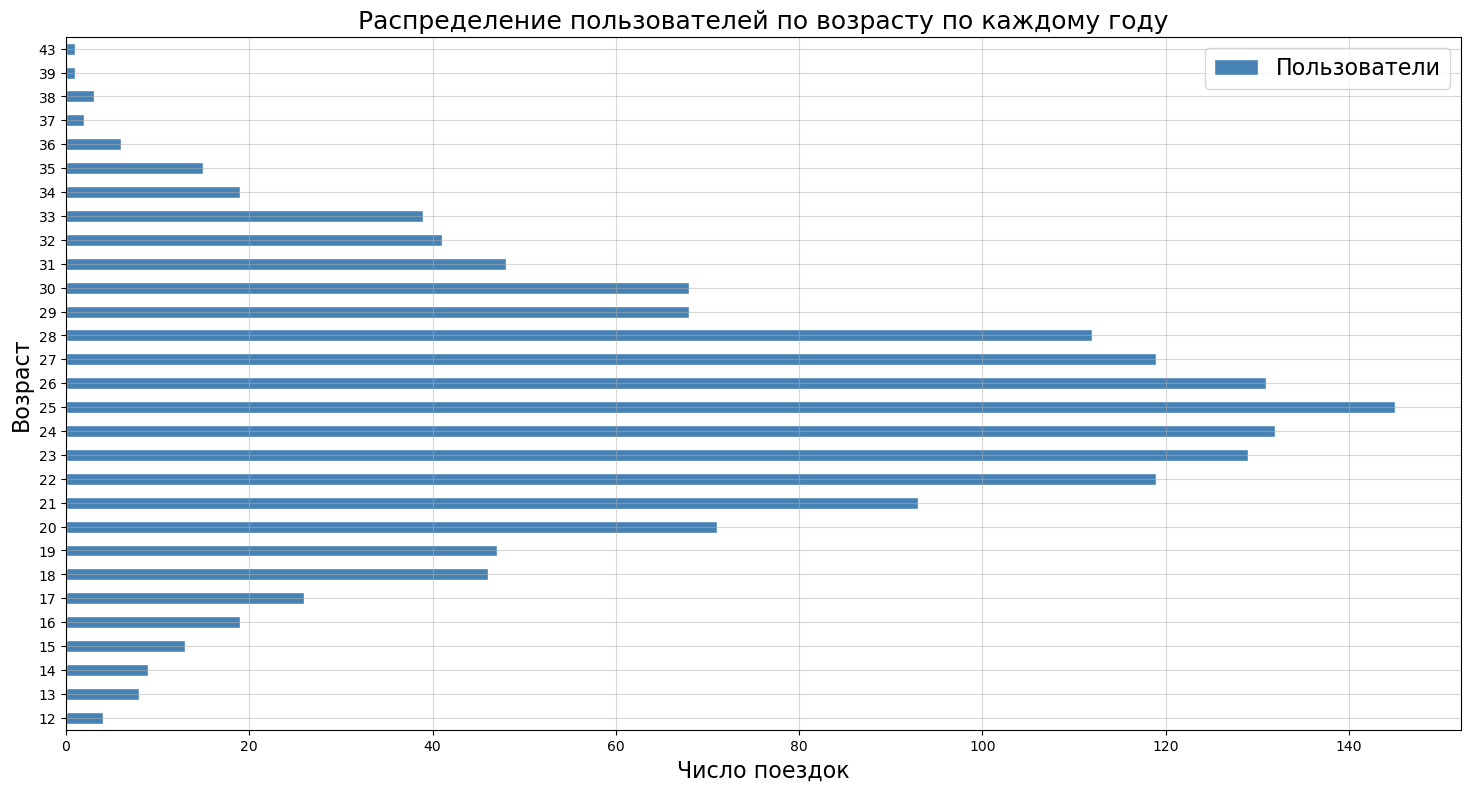

In [37]:
users_data['age'].value_counts().sort_index(ascending=True).plot(kind='barh', figsize=(18, 9), color='steelblue', ec='white')
plt.title('Распределение пользователей по возрасту по каждому году', fontsize=18)
plt.xlabel('Число поездок', fontsize=16)
plt.ylabel('Возраст', fontsize=16)
plt.legend(['Пользователи'], loc='upper right', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

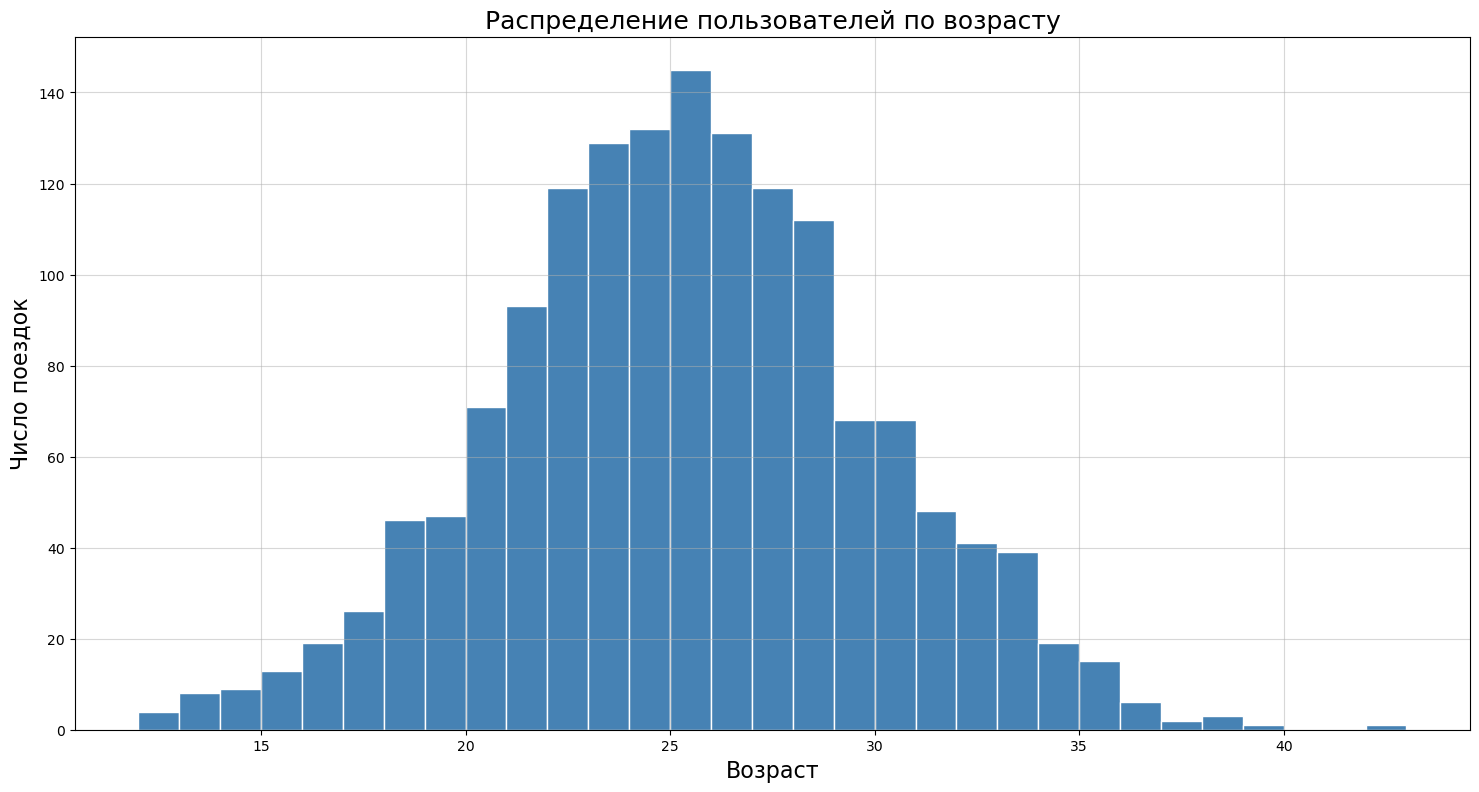

In [38]:
users_age = users_data['age'].sort_index(ascending=True)
plt.figure(figsize=(18,9))
plt.hist(users_age, bins=31, range=(12, 43), color='steelblue', ec='white')
plt.title('Распределение пользователей по возрасту', fontsize=18)
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Число поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Доля каждой возрастной категории в общем объеме пользователей.

In [39]:
persent = users_data['age'].value_counts().sort_index()/users_data['age'].value_counts().sort_index().sum() * 100
print(persent.round(2).sort_values(ascending=False))

age
25    9.45
24    8.60
26    8.54
23    8.41
27    7.76
22    7.76
28    7.30
21    6.06
20    4.63
30    4.43
29    4.43
31    3.13
19    3.06
18    3.00
32    2.67
33    2.54
17    1.69
34    1.24
16    1.24
35    0.98
15    0.85
14    0.59
13    0.52
36    0.39
12    0.26
38    0.20
37    0.13
39    0.07
43    0.07
Name: count, dtype: float64


Основные показатели описательной статистики возраста пользователей.

In [40]:
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Мода

In [41]:
users_data['age'].mode()

0    25
Name: age, dtype: int64

Дисперсия и стандартное отклонение

In [42]:
users_data['age'].var()

20.90653684988491

In [43]:
users_data['age'].var()**0.5

4.572366657419865

Минимальное и максимальное значения.

In [44]:
users_data['age'].min()

12

In [45]:
users_data['age'].max()

43

Размах и межквартильный размах.

In [46]:
users_data['age'].max() - users_data['age'].min()

31

In [47]:
st.iqr(users_data['age'])

6.0

Построим диаграмму размаха по столбцу возраста пользователей.

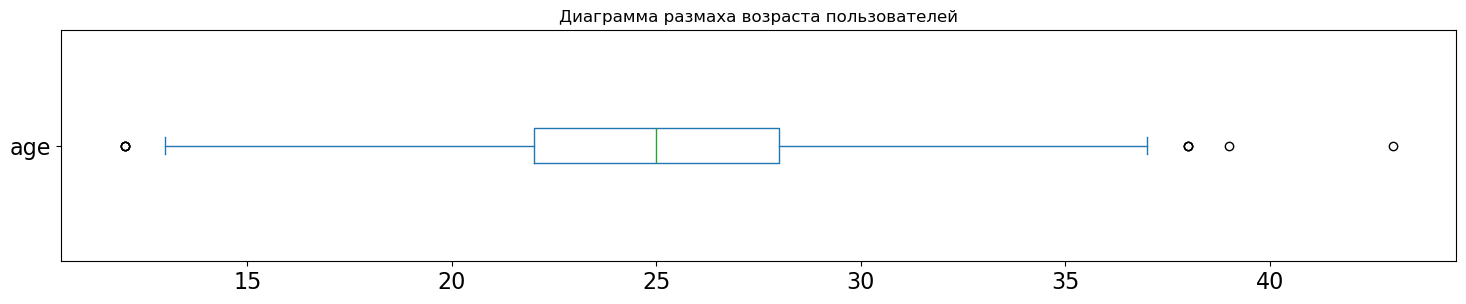

In [48]:
ax = users_data['age'].plot(
    kind='box', 
    vert=False,    
    figsize=(18, 3), 
    title = 'Диаграмма размаха возраста пользователей', 
    fontsize=16)
plt.show()

**Изучение городов пользователей.**

Распределение количества поездок по городам и построение гистограммы распределения.

In [49]:
users_data['city'].value_counts(ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Гистограмма распределения числа поездок по городам

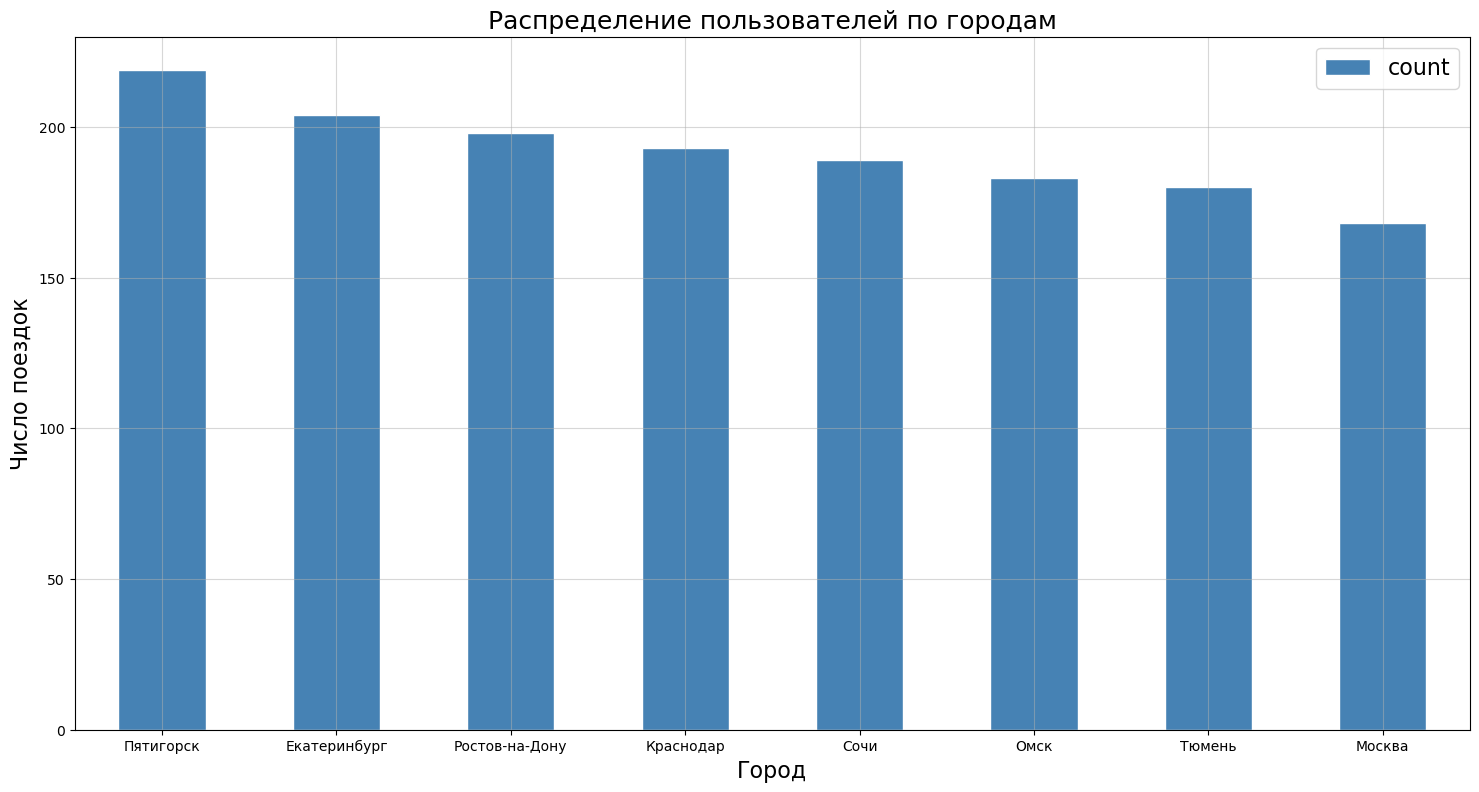

In [50]:
users_data['city'].value_counts().plot(kind='bar', figsize=(18, 9), color='steelblue', ec='white')
plt.title('Распределение пользователей по городам', fontsize=18)
plt.xlabel('Город', fontsize=16)
plt.ylabel('Число поездок', fontsize=16)
plt.xticks(rotation=0)
plt.legend(loc='upper right', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Выведем описательные статистики по столбцу 'city'

In [51]:
users_data['city'].value_counts(ascending=False).describe()

count      8.000000
mean     191.750000
std       15.672998
min      168.000000
25%      182.250000
50%      191.000000
75%      199.500000
max      219.000000
Name: count, dtype: float64

**Изучение подписок пользователей.**

Общее количество подписок по типам и визуализация доли кажой подписки.

In [52]:
users_data['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

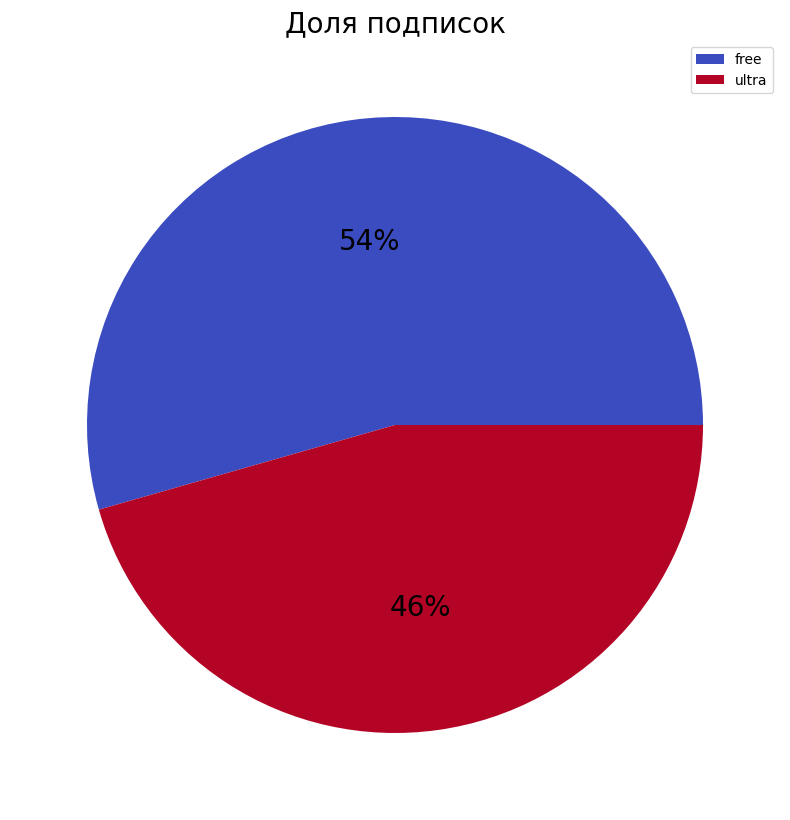

In [53]:
users_data['subscription_type'].value_counts().plot(
    kind='pie', 
    figsize=(10, 10), 
    cmap='coolwarm', 
    labels=None, 
    label='', 
    autopct='%1.0f%%', 
    legend=True, 
    fontsize=20)
plt.title('Доля подписок', fontsize=20)
plt.show(close=None, block=None)

Распределение количества подписок в городах по типам.

In [56]:
users_data.pivot_table(index ='city', 
                       columns = 'subscription_type',
                       aggfunc = 'count', observed=False)

age       name       user_id      
subscription_type free ultra free ultra    free ultra
city                                                 
Екатеринбург       112    92  112    92     112    92
Краснодар          112    81  112    81     112    81
Москва              84    84   84    84      84    84
Омск                92    91   92    91      92    91
Пятигорск          125    94  125    94     125    94
Ростов-на-Дону     109    89  109    89     109    89
Сочи               103    86  103    86     103    86
Тюмень              98    82   98    82      98    82

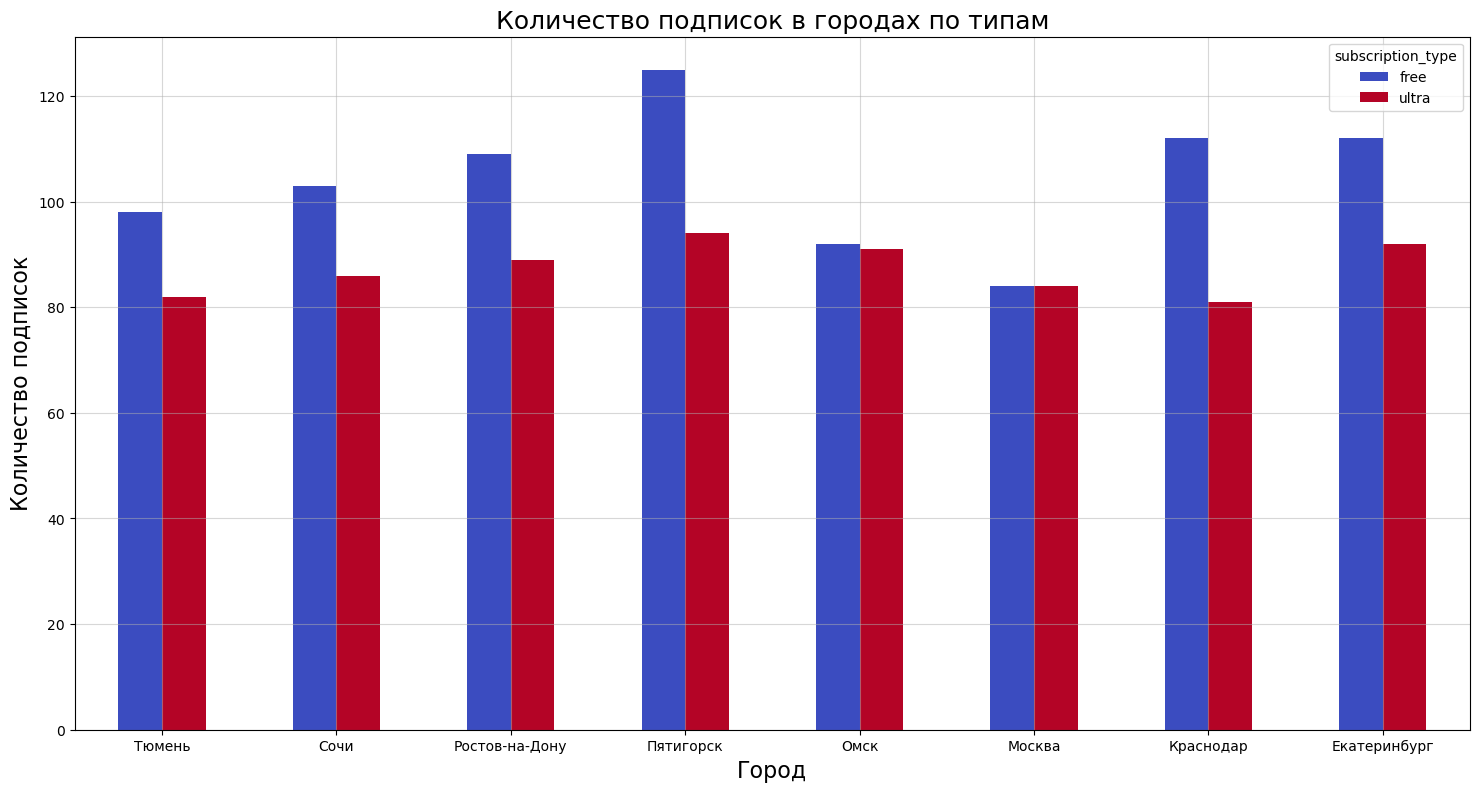

In [57]:
users_data.pivot_table(index ='city', 
                       columns = 'subscription_type',
                       values = 'user_id',
                       aggfunc = 'count', observed=False).sort_index(ascending=False).plot(kind='bar', cmap='coolwarm', figsize=(18, 9)) 
plt.title('Количество подписок в городах по типам', fontsize=18)
plt.xlabel('Город', fontsize=16)
plt.ylabel('Количество подписок', fontsize=16)
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Распределение количества подписок в зависимости от возраста.

In [58]:
users_data.pivot_table(index ='age', 
                       columns = 'subscription_type',
                       aggfunc = 'count', observed=False)

city       name       user_id      
subscription_type free ultra free ultra    free ultra
age                                                  
12                   1     3    1     3       1     3
13                   4     4    4     4       4     4
14                   5     4    5     4       5     4
15                   4     9    4     9       4     9
16                  11     8   11     8      11     8
17                  13    13   13    13      13    13
18                  27    19   27    19      27    19
19                  18    29   18    29      18    29
20                  37    34   37    34      37    34
21                  59    34   59    34      59    34
22                  72    47   72    47      72    47
23                  67    62   67    62      67    62
24                  68    64   68    64      68    64
25                  85    60   85    60      85    60
26                  78    53   78    53      78    53
27                  65    54   65    54      65    54
28                  70    42   70    42      70    42
29                  33    35   33    35      33    35
30                  39    29   39    29      39    29
31                  18    30   18    30      18    30
32                  16    25   16    25      16    25
33                  17    22   17    22      17    22
34                  13     6   13     6      13     6
35                   6     9    6     9       6     9
36                   5     1    5     1       5     1
37                   1     1    1     1       1     1
38                   1     2    1     2       1     2
39                   1     0    1     0       1     0
43                   1     0    1     0       1     0

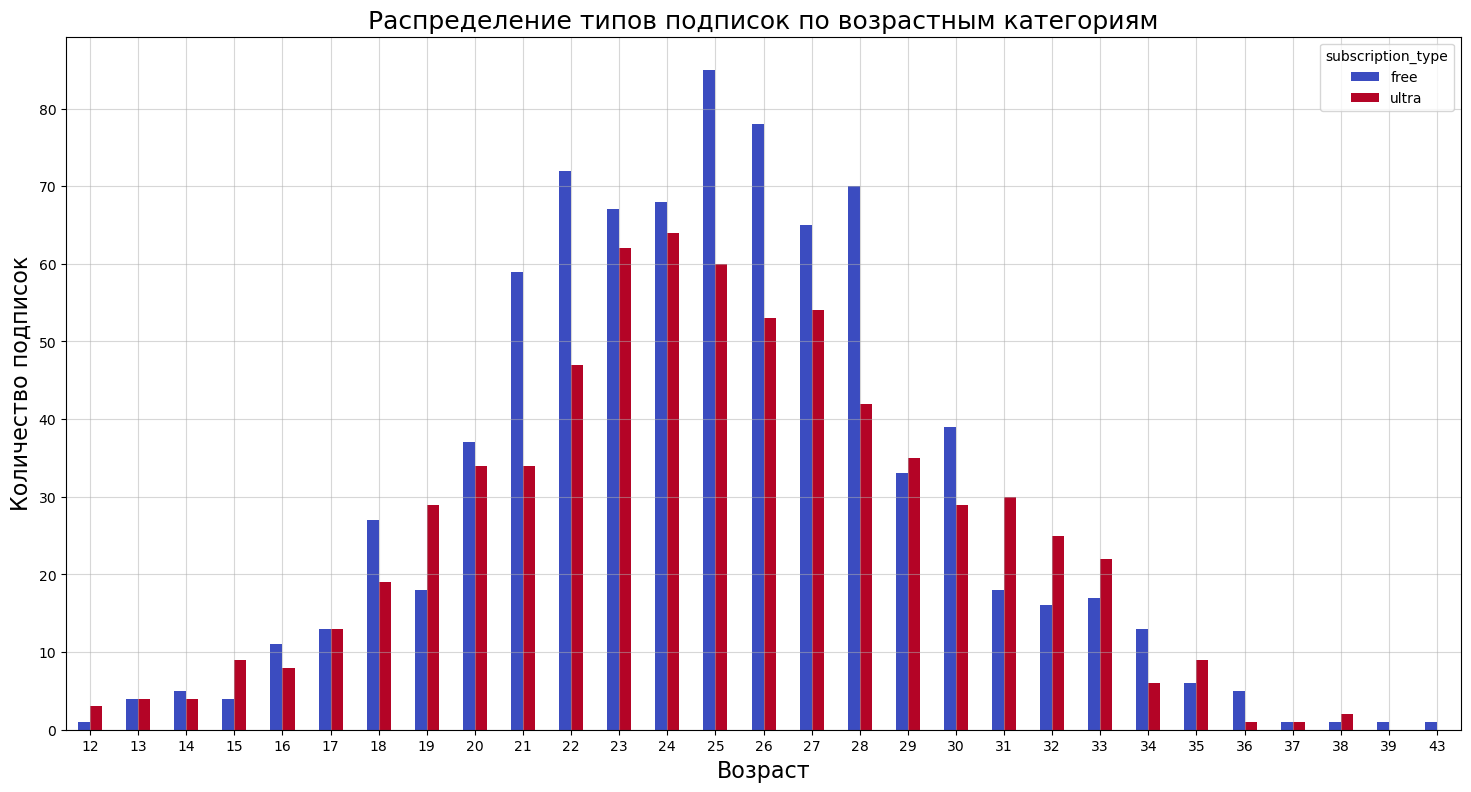

In [59]:
users_data.pivot_table(index ='age', 
                       columns = 'subscription_type',
                       values = 'user_id',
                       aggfunc = 'count', observed=False).sort_index(ascending=True).plot(kind='bar', cmap='coolwarm', figsize=(18, 9)) 
plt.title('Распределение типов подписок по возрастным категориям', fontsize=18)
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Количество подписок', fontsize=16)
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

**Выводы по итогам изучения набора данных 'users_data':**

1. Пользователями самокатов являются люди в возрасте от 12 до 43 лет. Средний и медианный возраст пользователей практически равны и составляют 24,9 и 25 лет соответственно, мода возраста также равна 25 годам. Пользователи по возрасте от 23 до 27 лет включительно являются наибольшими возрастными группами, входят в топ 5 по возрасту и занимают 39.7 процентов всех пользователей.

2. На диаграмме размаха возраста пользователей сверху и снизу имеются выбросы. Выбросы находятся в пределах 3 стандартных отклонений как в одну сторону, так и в другую. Однако, аномальными все же следуют считать выбросы снизу для пользователей самокатов с 12 до 18 лет, так как этот возраст является низким для управления механическими транспортными средствами. В верхнем диапазоне возраста также находится небольшое количество значений. В целом, возможно к набору данных применить межквартильных размах 25%-75% для среза верхних и нижних возрастов, при котором значения среднего и медианы не изменяются, размах между минимальным и максимальным значениями значительно сократится, а стандартное отклонение уменьшится более чем в три раза.

3. В наборе данных представлены пользователи из 8 городов, количество которых между городами распределено равномерно в интервале от 11% до 14%. Наибольшее число пользователей в Пятигорске (219 человек), наименьшее в Москве (168). Среднее количество пользователей и медианное пратически совпадают и составляют 191.7 и 191 соответственно. Вероятнее всего малое число в Москве по сравнению с другими городами связано с различными факторами.

4. Во-первых, в Москве уровень дохода населения выше, чем в других регионах, который позволяет приобрести самокат или автомобиль, а не брать его в аренду. Во-вторых, в Москве расстояния от дома до работы и обратно, или от дома до иных объектов может значительно превышать это же расстояние по сравнению с другими небольшими и компактно построенными городами и быть тяжело преодолимым на самокате. В третьих, несколько городов с большим количеством пользователей находятся на юге России (Сочи, Краснодар, Пятигорск, Ростов-на-Дону), что является также более благоприпятствующим фактором для поездок на самокате.

5. Каждый пользователь имеет одну из двух видов подписок - бесплатную или ультра. Доля пользователей имеющих бесплатную подписку составляет 54% (835 подписок), а доля имеющих подписку ультра - 46% (699 подписок). Таким образом, можно сделать вывод о практически равномерном распределении по подпискам с небольшим смещением в торону бесплатных подписок.

6. Ни в одном из городов общее число платных подписок не превышает общее число бесплатных. Только в Москве эти показатели равны (84 платных и 84 бесплатных).

7. В целом рост платных подписок идет до 24 лет, а бесплатных подписок до 25 лет. После этого, число подписок равномерно идет на снижение. Также выявлено, что в отдельных возрастных категориях число платных подписок превышает число бесплатных: 15, 19, 31, 32, 33, 35 и 38 лет.

##### Изучение датафрейма 'rides_data'.

Вывод общей информации и основных показателей описательной статистики.

In [60]:
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [61]:
rides_data.describe()

,user_id,distance,duration,date,month
count,18068.000000,18068.000000,18068.000000,18068,18068.000000
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00,12.000000
std,434.734317,1116.831209,6.091051,NaN,3.437410


**Изучение расстояний.**

In [62]:
rides_data['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Размах и межквартильный размах.

In [63]:
rides_data['distance'].max() - rides_data['distance'].min()

7210.152061672838

In [64]:
st.iqr(rides_data['distance'])

1232.9963753558854

Диаграмма размаха.

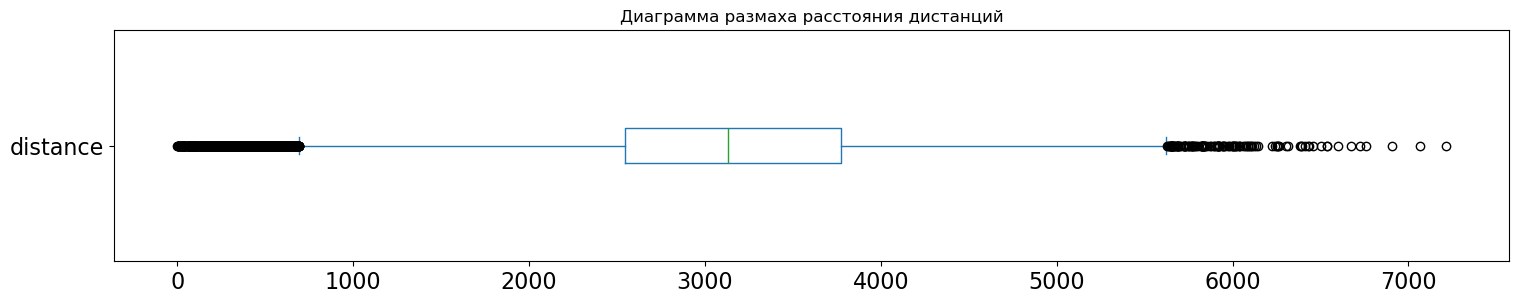

In [65]:
ax = rides_data['distance'].plot(
    kind='box', 
    vert=False,    
    figsize=(18, 3), 
    title = 'Диаграмма размаха расстояния дистанций', 
    fontsize=16)
plt.show()

Корреляция дистанции и продолжительности поездки.

In [66]:
rides_data['distance'].corr(rides_data['duration'])

0.5367776552505348

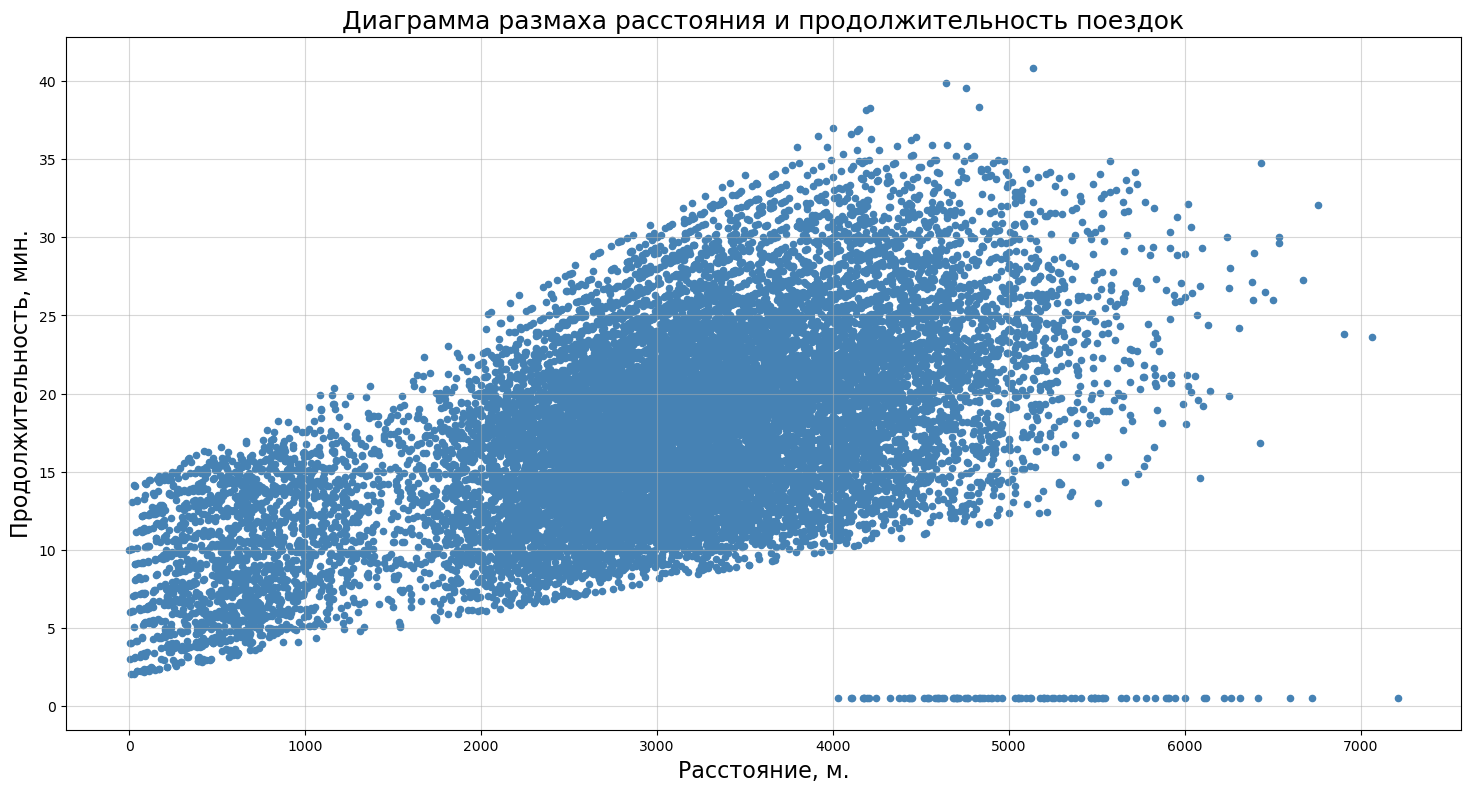

In [67]:
rides_data.plot(x='distance', y='duration', kind='scatter', figsize=(18, 9), color='steelblue')
plt.title('Диаграмма размаха расстояния и продолжительность поездок', fontsize=18)
plt.xlabel('Расстояние, м.', fontsize=16)
plt.ylabel('Продолжительность, мин.', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

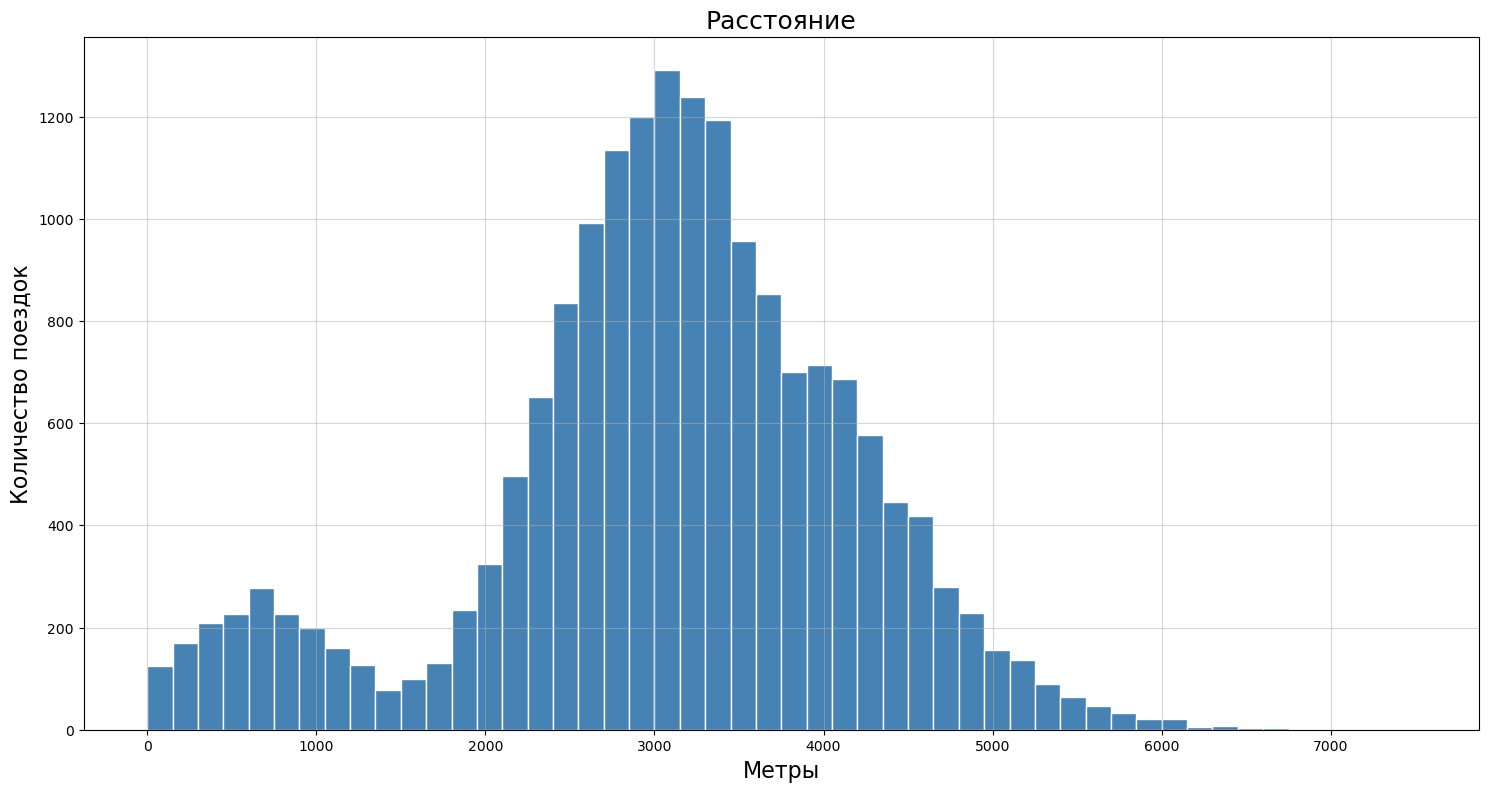

In [68]:
plt.figure(figsize=(18,9))
plt.hist(rides_data['distance'], bins=50, range=(0, 7500), color='steelblue', ec='white')
plt.title('Расстояние', fontsize=18)
plt.xlabel('Метры', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

На гистограмме в распределении явно прослеживаются два пика, первый характеризует часть поездок на дистанции от 0 до 1500 метров (малая часть поездок) и основная большая часть поездок в интервале от 1500 метров до 6000 метров.

**Изучение продолжительности сессий.**

In [69]:
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

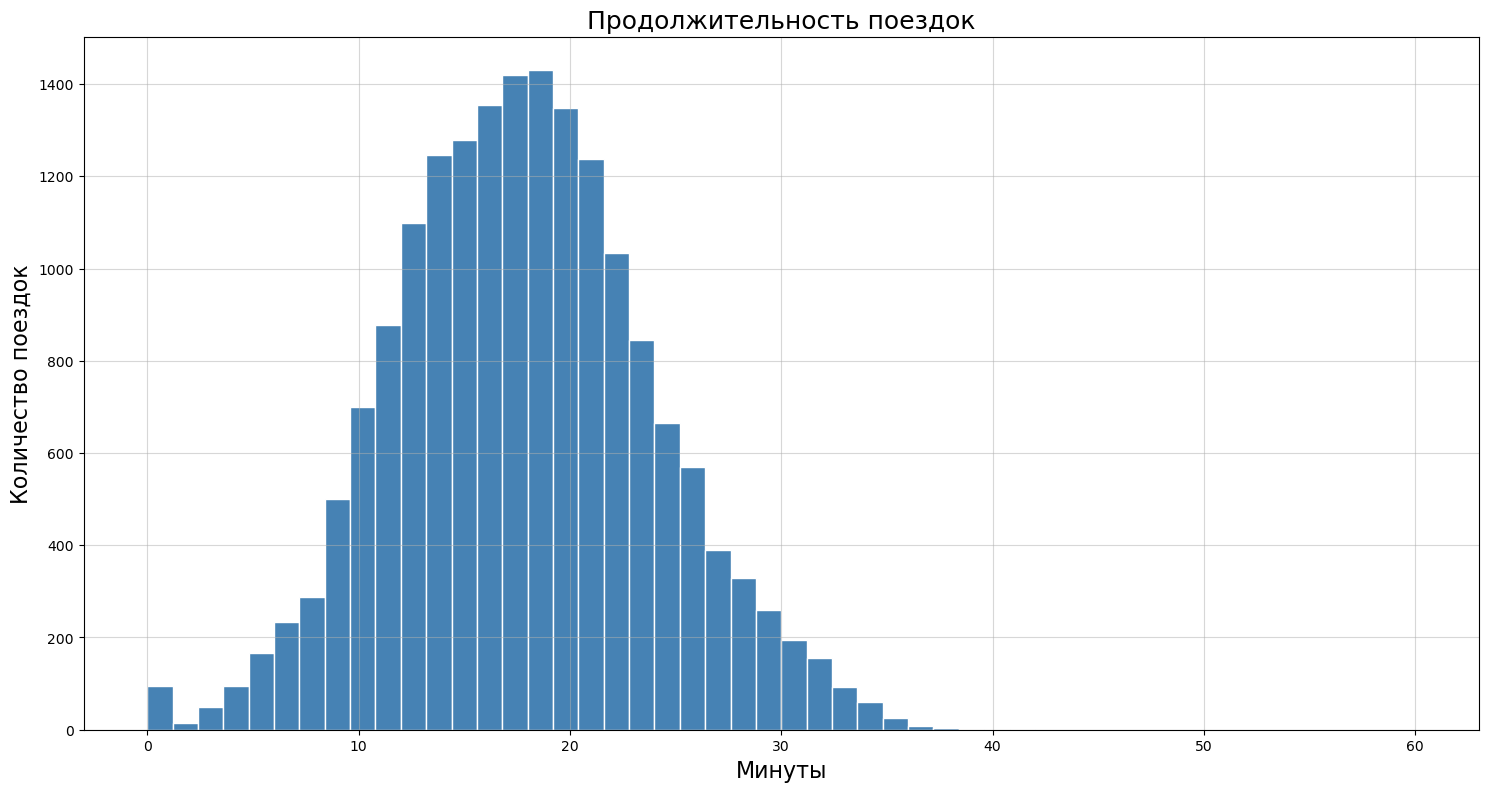

In [70]:
plt.figure(figsize=(18,9))
plt.hist(rides_data['duration'], bins=50, range=(0, 60), color='steelblue', ec='white')
plt.title('Продолжительность поездок', fontsize=18)
plt.xlabel('Минуты', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Распределение продолжительности поездок нормальное с центральным средним и медианным значением в 17 мин.

**Изучение дат.**

Распределение поездок по дням недели.

In [71]:
rides_data['date'].dt.day_name().value_counts()

date
Thursday     2667
Monday       2613
Saturday     2605
Tuesday      2571
Wednesday    2567
Friday       2559
Sunday       2486
Name: count, dtype: int64

Постоим визуализацию распределения поездок по дням недели.

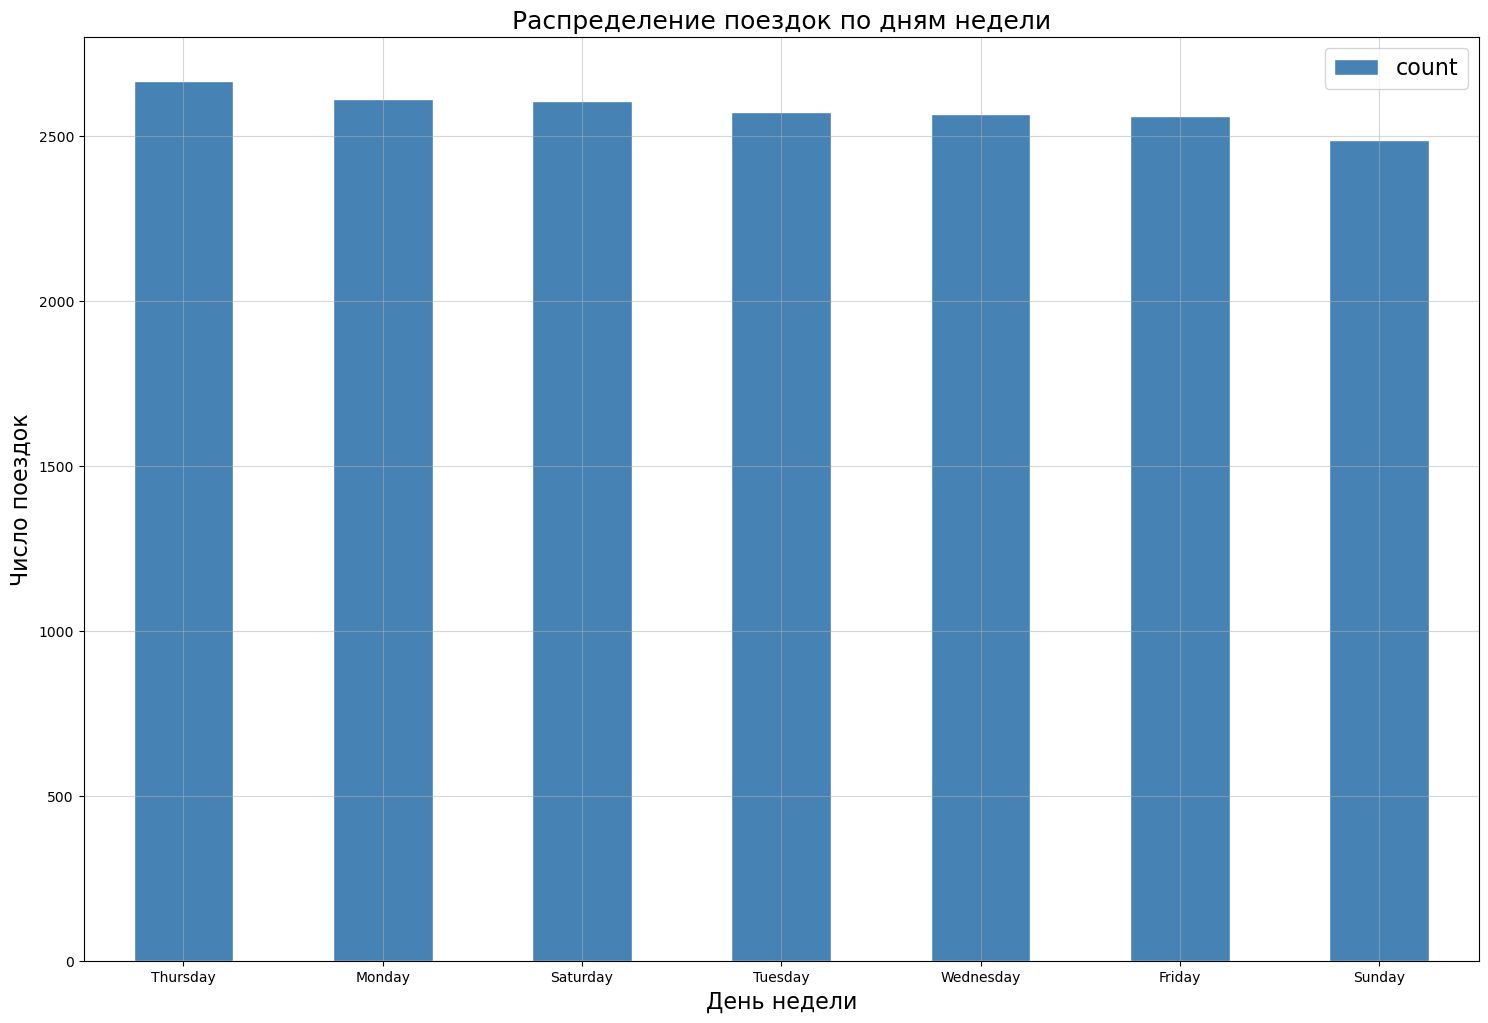

In [72]:
rides_data['date'].dt.day_name().value_counts().plot(
    kind='bar', figsize=(18, 12), color='steelblue', ec='white')
plt.title('Распределение поездок по дням недели', fontsize=18)
plt.xlabel('День недели', fontsize=16)
plt.ylabel('Число поездок', fontsize=16)
plt.xticks(rotation=0)
plt.legend(loc='upper right', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Как видно, распределение поездок по дням недели распределно практически равномерно, нет резких снижейни как в будние дни, так и в выходные.

Распределение поездок по месяцам

In [73]:
rides_data['date'].dt.month_name().value_counts()

date
January      1585
May          1560
June         1553
March        1544
July         1529
December     1527
August       1518
September    1517
April        1506
October      1475
November     1418
February     1336
Name: count, dtype: int64

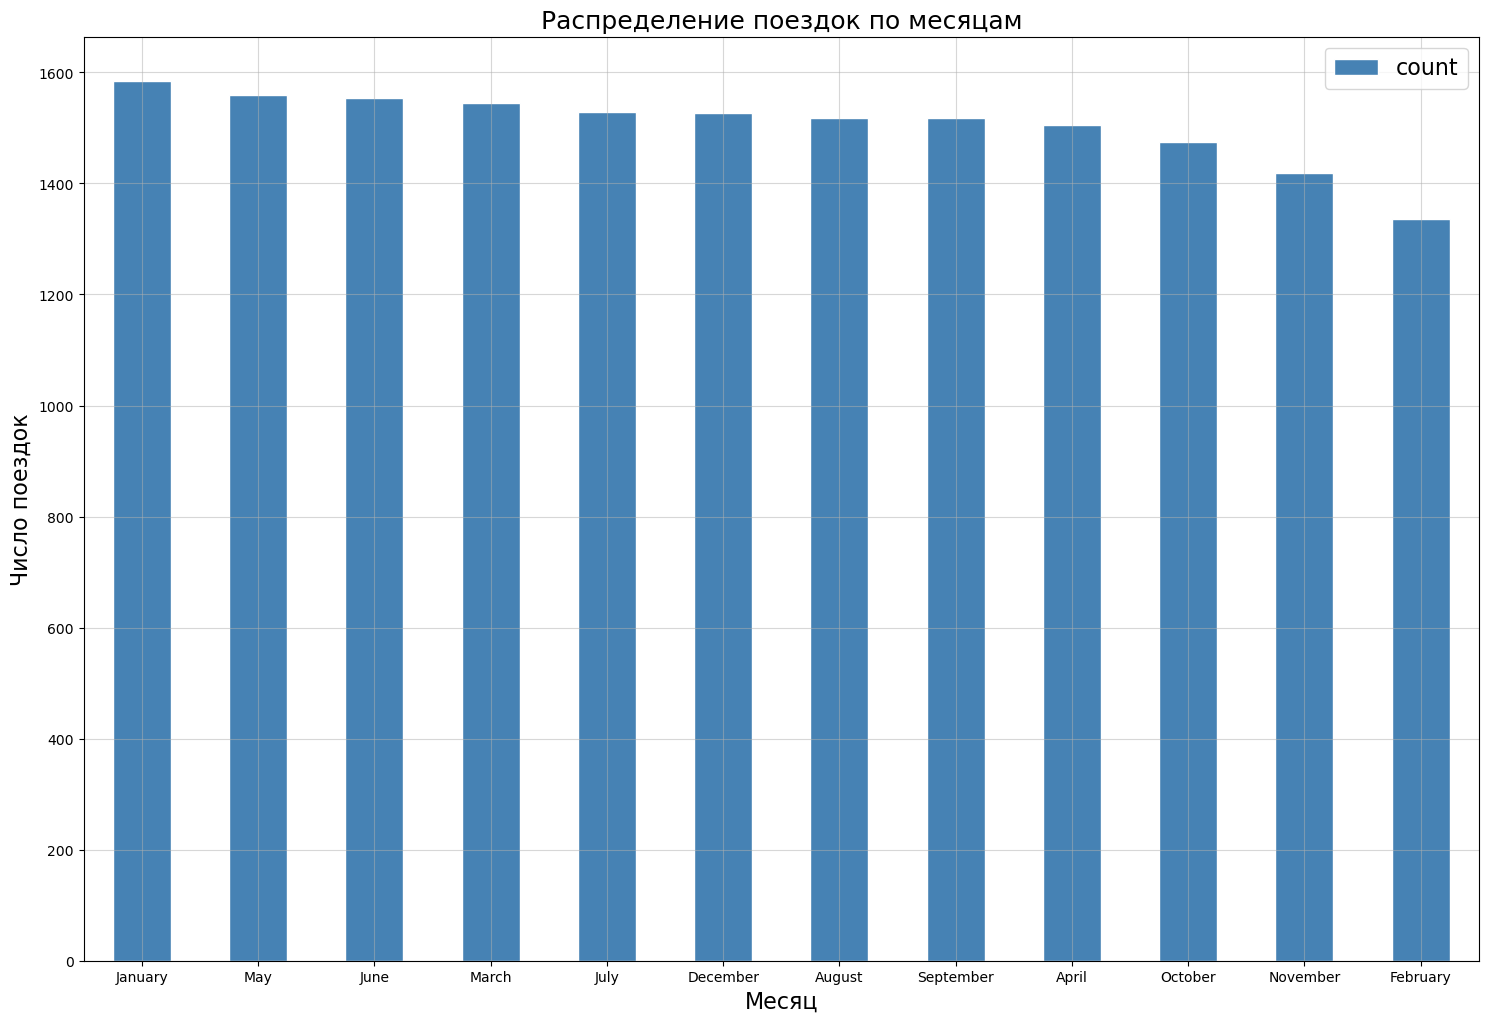

In [74]:
rides_data['date'].dt.month_name().value_counts().plot(
    kind='bar', figsize=(18, 12), color='steelblue', ec='white')
plt.title('Распределение поездок по месяцам', fontsize=18)
plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Число поездок', fontsize=16)
plt.xticks(rotation=0)
plt.legend(loc='upper right', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Распределение поездок по месяцам недели распределно также практически равномерно, с тендейцией небольшого снижения в осенне-зимний период.

**Выводы по итогам изучения набора данных 'rides_data':**

1. Набор данных содержит большое количество уникальных значений расстояния дистанций, среди которых минимальное расстояние зафиксировано менее 1 метра, а максимальное 7211 метр. Среднее и медианные значения практически равны (3070.6 и 3133.6 соответственно). Размах равен 7210 и выходит за пределы нескольких стандартных отклонений (1116.8) вниз и вверх.

2. Продолжительность поездок также содержить большое число уникальных значений. Минимальное значение продолжительности 0.5 минуты, а максимальное 40.8 минут. Длительность средней сессии зафиксирована в 17.8 мин., а медианная в 17.6 мин. Стандартное отклонение - 6.0 мин.

3. Между расстоянием поездки и продолжительностью сессии имеется средняя корреляция (0.53). Имеется явная закономерность при увеличении расстояния растет время поездки и, наоборот.

4. Изучение календарных дат поездок позволило выявить следующее. По месяцам в году все поездки распределены практически равномерно, но имеется незначительное снижение в осенне-зимний период. Распределение поездок по дням недели также имеет равномерную структуру, которая показывает отсутствие каких-либо закономерностей по увеличению или снижению числа поездок в будние дни или в выходные дни.

#### Шаг 4. Объединение данных

##### Объединение наборов данных.

Объединим датафреймы 'users_data' и 'rides_data'.

In [75]:
temp = users_data.merge(rides_data, on='user_id', how='left')

Проведем проверку выполненного объединения.

In [76]:
temp.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


Далее присоединим оставшийся датафрейм 'subscriptions_data' к объединенному набору данных.

In [77]:
data = temp.merge(subscriptions_data, on='subscription_type', how='left')

Проведем проверку выполненного объединения.

In [78]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Выведим информацию о наборах данных до и после объединения.

In [79]:
users_data.info()
print()
rides_data.info()
print()
subscriptions_data.info()
print()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   user_id            1534 non-null   int64   
 1   name               1534 non-null   object  
 2   age                1534 non-null   int64   
 3   city               1534 non-null   category
 4   subscription_type  1534 non-null   category
dtypes: category(2), int64(2), object(1)
memory usage: 51.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
mem

In [80]:
print(f'Размер набора данных users_data: {users_data.shape}')
print()
print(f'Размер набора данных users_data: {rides_data.shape}')
print()
print(f'Размер набора данных users_data: {subscriptions_data.shape}')
print()
print(f'Размер набора данных users_data: {data.shape}')

Размер набора данных users_data: (1534, 5)

Размер набора данных users_data: (18068, 5)

Размер набора данных users_data: (2, 4)

Размер набора данных users_data: (18068, 12)


Проверим повторно наличие пропусков после объединения наборов данных.

In [81]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Создадим два датафрейма с данными о пользователях без подписки и пользователями с подпиской.

In [82]:
free_data = data[data['subscription_type'] == 'free']
free_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Выведем основную информацию о новой таблице

In [83]:
free_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  category      
 4   subscription_type  11568 non-null  category      
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(2), int32(1), int64(5), object(1)
memory usage: 972.0+ KB


In [84]:
print(f'Размер набора данных users_data: {free_data.shape}')

Размер набора данных users_data: (11568, 12)


Проверим наличие пропусков в новом наборе данных.

In [85]:
free_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Визуализируем расстояние и время поездок пользователей с бесплатной подпиской.

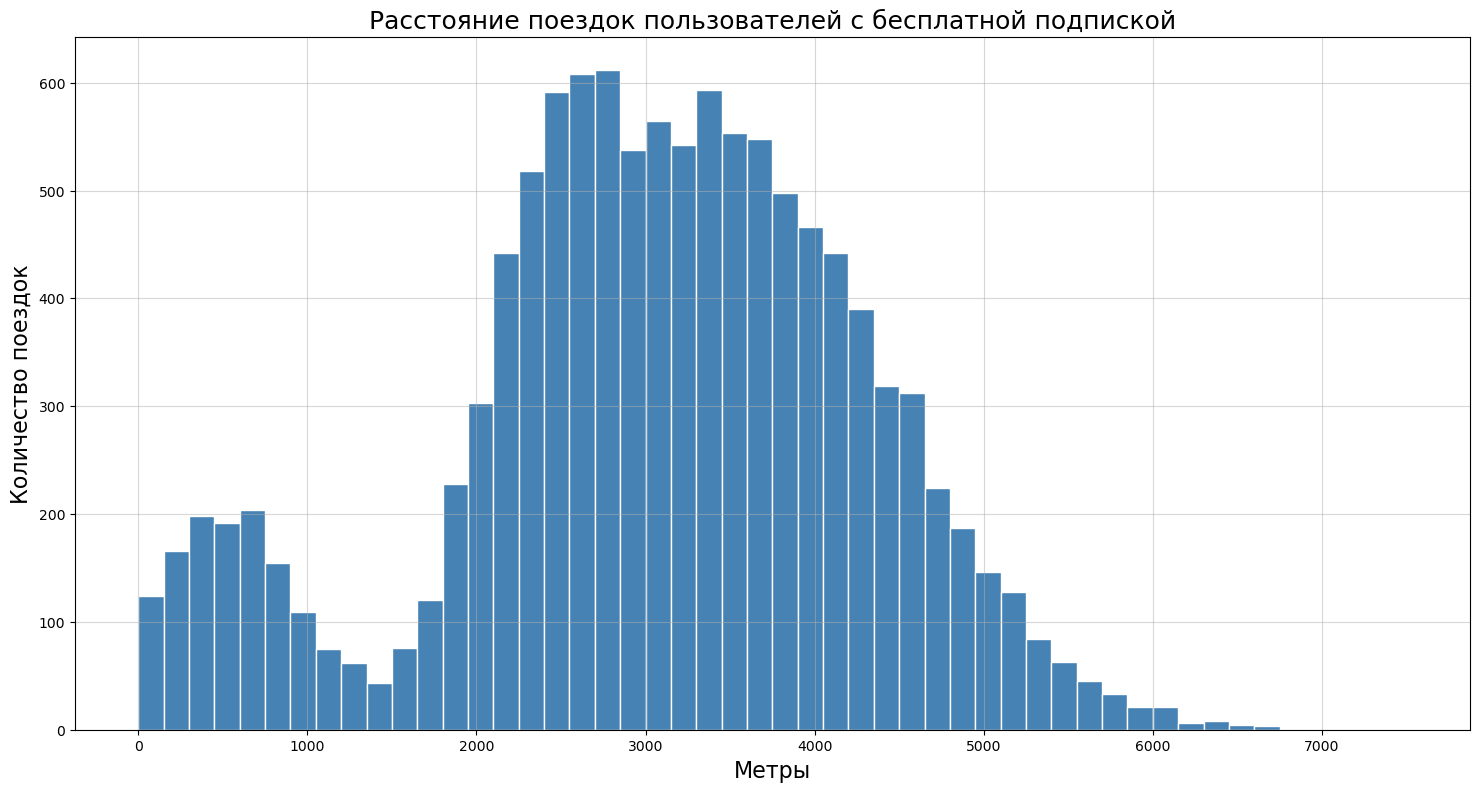

In [86]:
plt.figure(figsize=(18,9))
plt.hist(free_data['distance'], bins=50, range=(0, 7500), color='steelblue', ec='white')
plt.title('Расстояние поездок пользователей с бесплатной подпиской', fontsize=18)
plt.xlabel('Метры', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

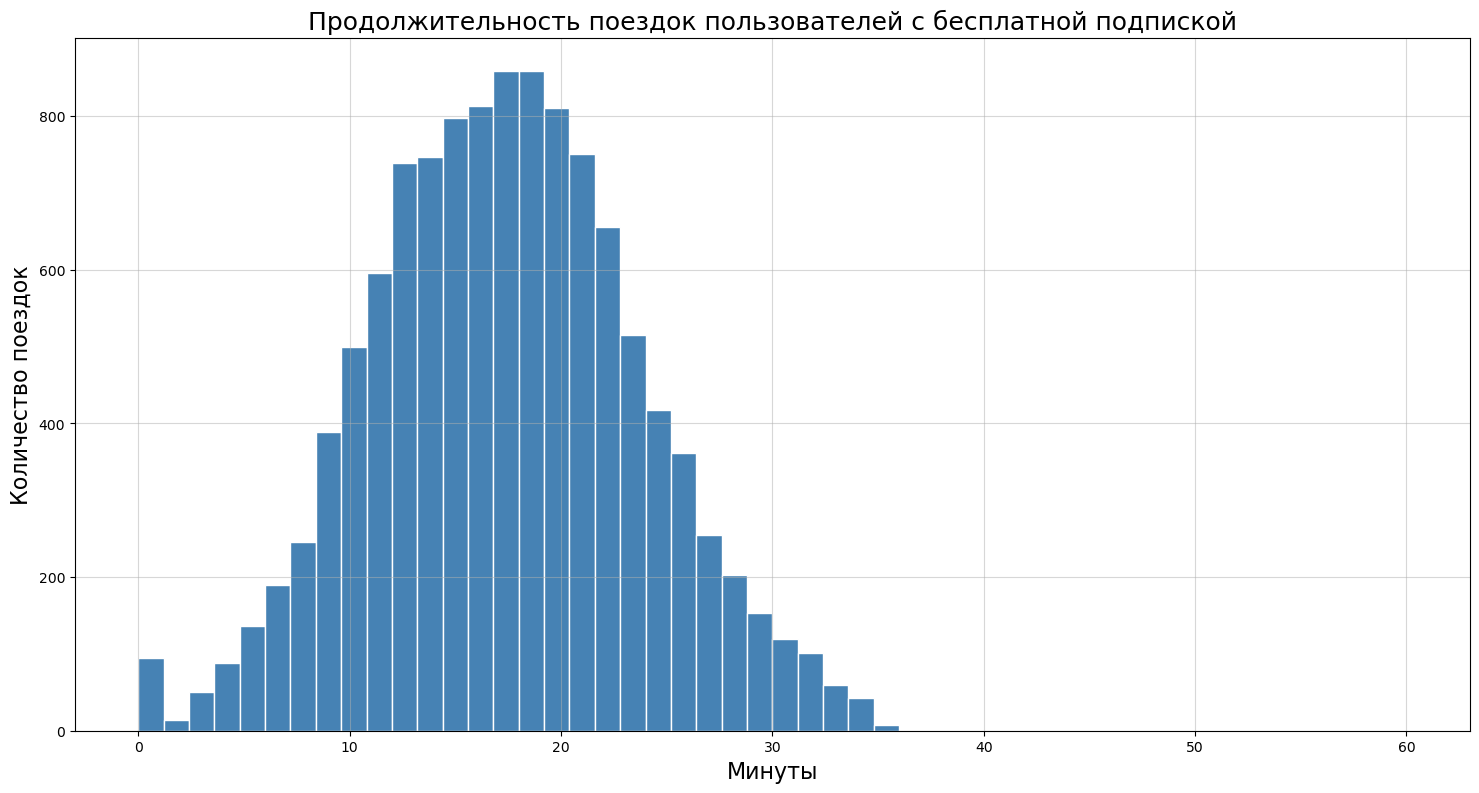

In [87]:
plt.figure(figsize=(18,9))
plt.hist(free_data['duration'], bins=50, range=(0, 60), color='steelblue', ec='white')
plt.title('Продолжительность поездок пользователей с бесплатной подпиской', fontsize=18)
plt.xlabel('Минуты', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Создадим датафрейм с пользователями с платной подпиской.

In [88]:
ultra_data = data[data['subscription_type'] == 'ultra']
ultra_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


Визуализируем расстояние и время поездок пользователей с платной подпиской.

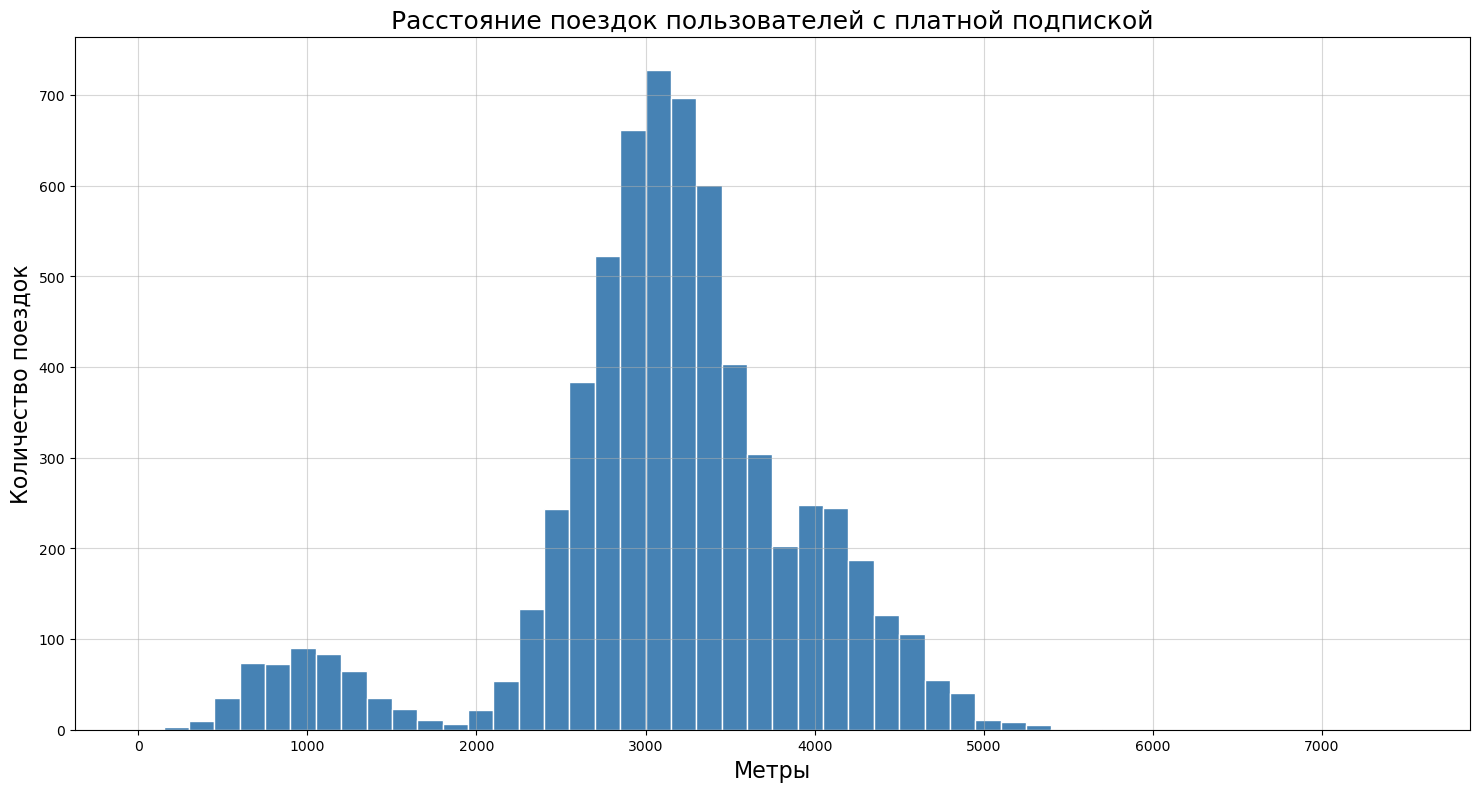

In [89]:
plt.figure(figsize=(18,9))
plt.hist(ultra_data['distance'], bins=50, range=(0, 7500), color='steelblue', ec='white')
plt.title('Расстояние поездок пользователей с платной подпиской', fontsize=18)
plt.xlabel('Метры', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

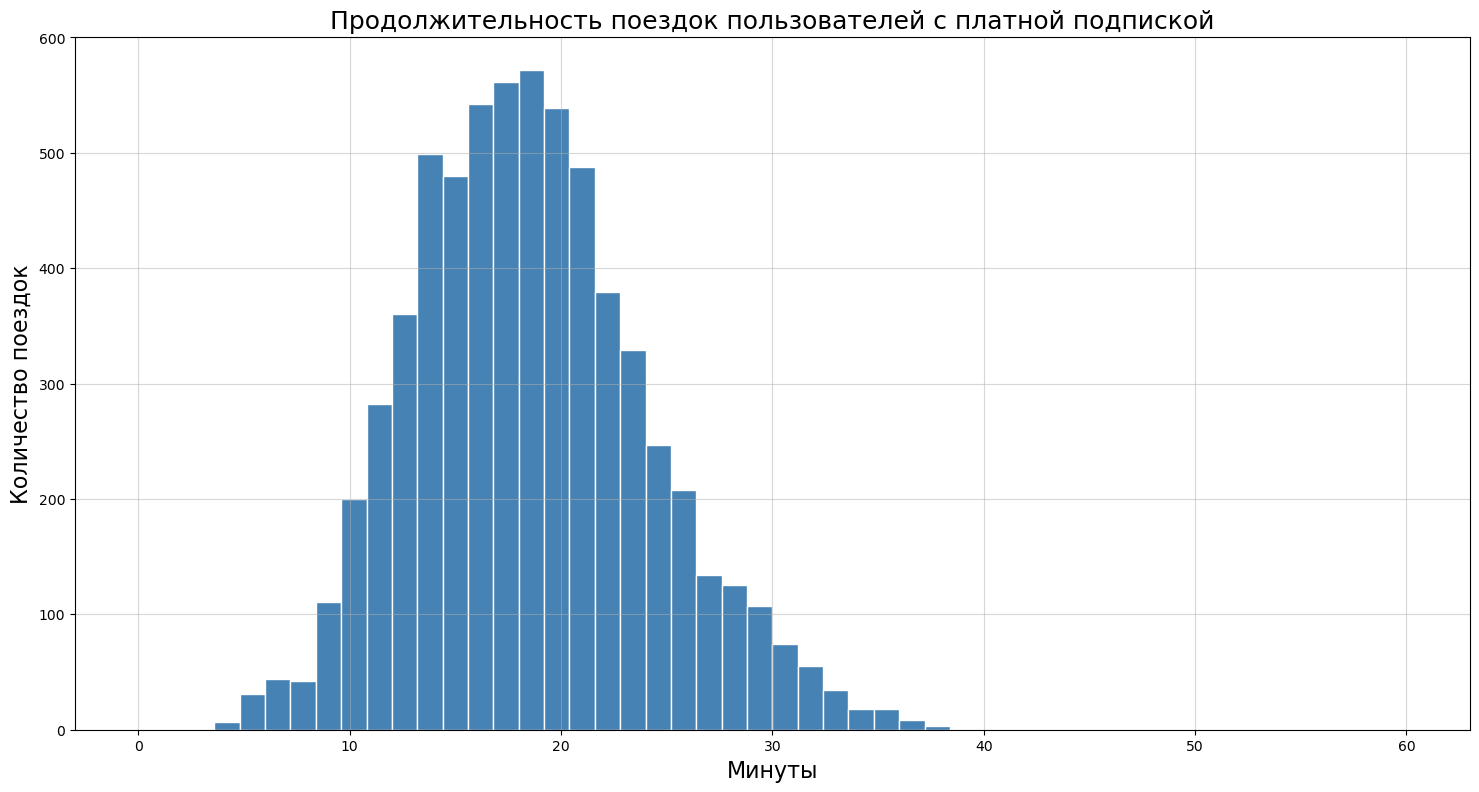

In [90]:
plt.figure(figsize=(18,9))
plt.hist(ultra_data['duration'], bins=50, range=(0, 60), color='steelblue', ec='white')
plt.title('Продолжительность поездок пользователей с платной подпиской', fontsize=18)
plt.xlabel('Минуты', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Дополним совместными гистограммами расстояния и продолжительности поездок на платном и бесплатном тарифах.

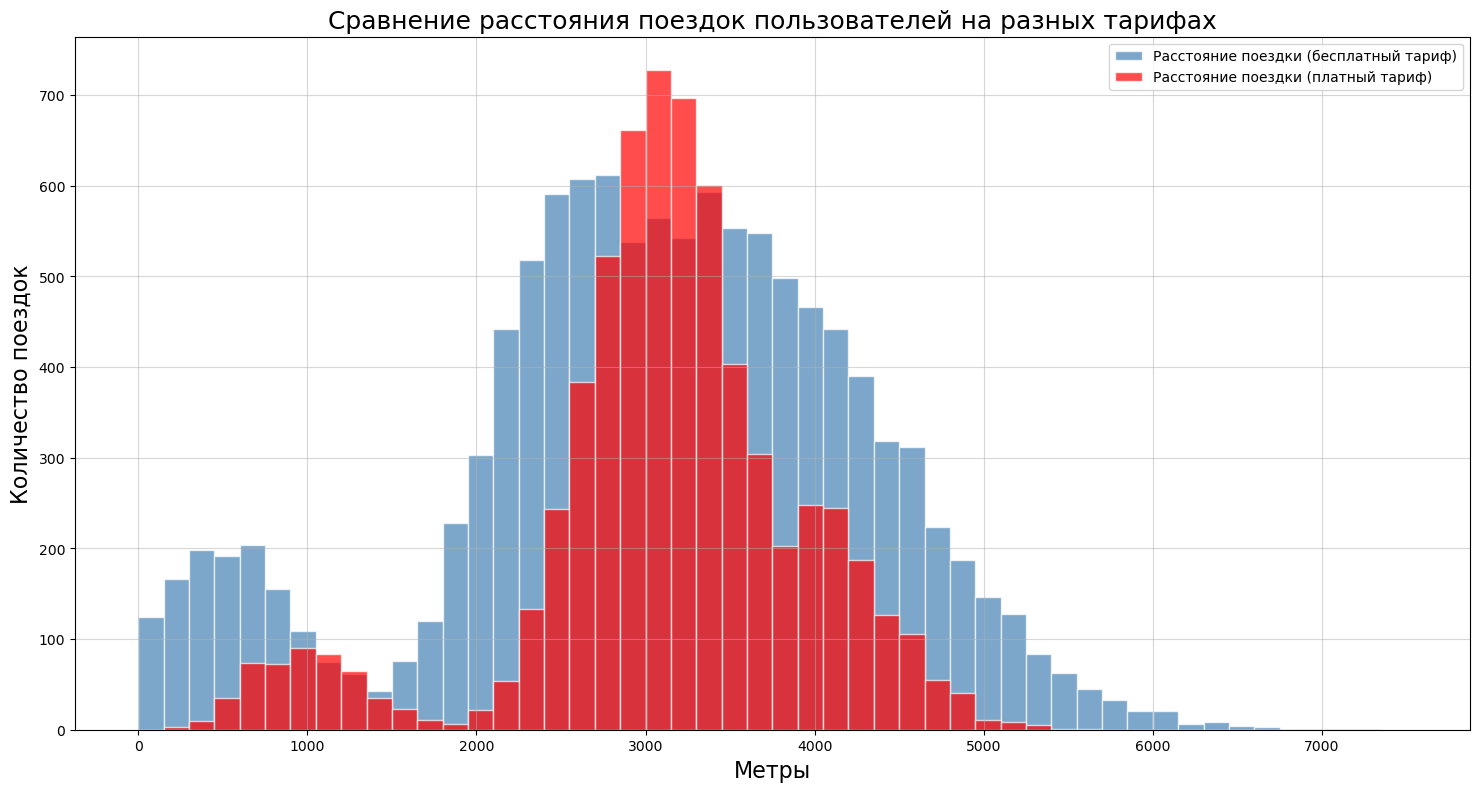

In [91]:
plt.figure(figsize=(18,9))
plt.hist(free_data['distance'], label='Расстояние поездки (бесплатный тариф)', 
         alpha=0.7, color='steelblue', ec='white', bins=50, range=(0, 7500))
plt.hist(ultra_data['distance'], label='Расстояние поездки (платный тариф)', 
         alpha=0.7, color='red', ec='white', bins=50, range=(0, 7500))
plt.title('Сравнение расстояния поездок пользователей на разных тарифах', fontsize=18)
plt.xlabel('Метры', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

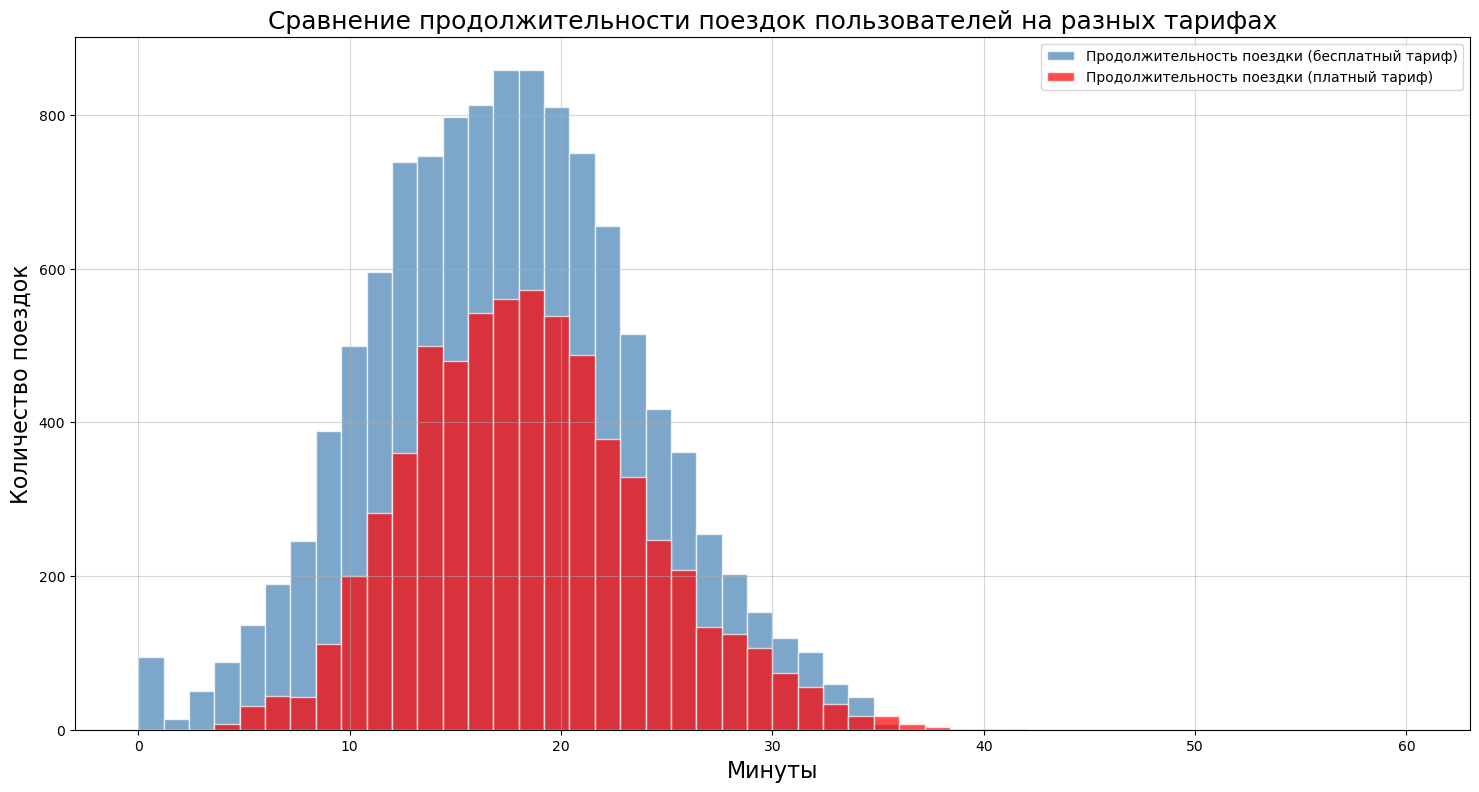

In [92]:
plt.figure(figsize=(18,9))
plt.hist(free_data['duration'], label='Продолжительность поездки (бесплатный тариф)', 
         alpha=0.7, color='steelblue', ec='white', bins=50, range=(0, 60))
plt.hist(ultra_data['duration'], label='Продолжительность поездки (платный тариф)', 
         alpha=0.7, color='red', ec='white', bins=50, range=(0, 60))
plt.title('Сравнение продолжительности поездок пользователей на разных тарифах', fontsize=18)
plt.xlabel('Минуты', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

Выведем основные показатели описательной статистики двух новых наборов данных.

In [93]:
free_data.describe().round(2)

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,11568.00,11568.00,11568.00,11568.00,11568,11568.00,11568.0,11568.0,11568.0
mean,1120.53,24.89,3045.50,17.39,2021-07-01 21:47:03.236514560,6.52,8.0,50.0,0.0
min,700.00,12.00,0.86,0.50,2021-01-01 00:00:00,1.00,8.0,50.0,0.0
25%,915.00,22.00,2366.56,12.96,2021-04-02 00:00:00,4.00,8.0,50.0,0.0
50%,1123.00,25.00,3114.65,17.33,2021-07-01 00:00:00,7.00,8.0,50.0,0.0
75%,1328.00,28.00,3905.70,21.59,2021-09-30 00:00:00,9.00,8.0,50.0,0.0
max,1534.00,43.00,7211.01,34.95,2021-12-30 00:00:00,12.00,8.0,50.0,0.0
std,241.17,4.48,1246.17,6.33,NaN,3.45,0.0,0.0,0.0


In [94]:
ultra_data.describe().round(2)

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,6500.00,6500.00,6500.00,6500.00,6500,6500.00,6500.0,6500.0,6500.0
mean,348.73,24.89,3115.45,18.54,2021-06-28 21:31:34.153846016,6.42,6.0,0.0,199.0
min,1.00,12.00,244.21,3.76,2021-01-01 00:00:00,1.00,6.0,0.0,199.0
25%,175.00,22.00,2785.44,14.52,2021-04-01 00:00:00,4.00,6.0,0.0,199.0
50%,351.00,25.00,3148.64,18.18,2021-06-27 00:00:00,6.00,6.0,0.0,199.0
75%,525.00,28.00,3560.57,21.88,2021-09-25 00:00:00,9.00,6.0,0.0,199.0
max,699.00,38.00,5699.77,40.82,2021-12-30 00:00:00,12.00,6.0,0.0,199.0
std,201.10,4.76,836.90,5.57,NaN,3.41,0.0,0.0,0.0


**Вывод:**

1. Среднее и медианное значения дистанции у пользователей с бесплатной подпиской практически совпадает с пользователями с платной подпиской, но все равно оказывается немного ниже.

2. Средняя и медианная продолжительность поездки также совсем немного ниже у пользователей с бесплатной подпиской.

3. Несмотря на это, максимальная длина дистанции различна: у пользователей с бесплатной подпиской 7.2 км, а у пользователей с платной подпиской 5.6 км.

4. Среднее, медианное и максимальное время поездки больше у пользователей с платной подпиской. 

5. Средний и медианный возраст у пользователей с подпиской и без одиноковый 24.8 и 25 соответственно. Значения минимального возраста также идентичны, а максимального возраста немного различаются. Вместе с тем, можно сделать вывод, что возраст заметного влияния на тип подписки не имеет.

#### Шаг 5. Подсчёт выручки

##### Создание датафрейма с агрегированными данными о поездках  с объединёнными данными : суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Проведем округление значений в столбце duration

In [95]:
data['duration'] = np.ceil(data['duration'])

Создадим сводную таблицу

In [96]:
data2 = data.pivot_table(
    index=('user_id', 'month'), 
    values=('distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'), 
    aggfunc=({'distance':{'count', 'sum'}, 'duration':'sum', 'minute_price': 'mean', 
              'start_ride_price':'mean', 'subscription_fee':'mean',}))

data2.columns = [
    'count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee']

data2.head(10)

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294      42.0           6.0               0.0   
        4          1    754.159807       7.0           6.0               0.0   
        8          2   6723.470560      46.0           6.0               0.0   
        10         2   5809.911100      32.0           6.0               0.0   
        11         3   7003.499363      56.0           6.0               0.0   
        12         2   6751.629942      28.0           6.0               0.0   
2       3          3  10187.723006      63.0           6.0               0.0   
        4          2   6164.381824      40.0           6.0               0.0   
        6          1   3255.338202      14.0           6.0               0.0   
        7          2   6780.722964      48.0           6.0               0.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
        12                199.0  
2       3                 199.0  
        4                 199.0  
        6                 199.0  
        7                 199.0

Добавим столбец с видом подписки

In [97]:
def subscription_category(row):
    if row['subscription_fee'] == 199:
        return 'ultra'
    else:
        return 'free'
data2['subscription_category'] = data2.apply(subscription_category, axis=1)

Проверим полученную таблицу на пропуски.

In [98]:
data2.isna().sum()

count                    0
distance                 0
duration                 0
minute_price             0
start_ride_price         0
subscription_fee         0
subscription_category    0
dtype: int64

Добавим в таблицу столбец с выручкой и посчитаем ее общую сумму

In [99]:
data2['revenue'] = (
    data2['start_ride_price'] * data2['count'] 
    + data2['minute_price'] * data2['duration'] 
    + data2['subscription_fee'])

total_revenue = data2['revenue'].sum()

print (f'Общая сумма выручки составила: {total_revenue} руб.')

Общая сумма выручки составила: 3878641.0 руб.


##### Дополнительные исследования выручки.

**Показатели за год.**

Беплатная подписка

In [94]:
year_free = data['date'].dt.year
result = free_data.groupby(year_free).agg(['sum', 'mean', 'count'])
result.round(2).T

date                           2021
user_id          sum    12962259.00
                 mean       1120.53
                 count     11568.00
age              sum      287966.00
                 mean         24.89
                 count     11568.00
distance         sum    35230289.42
                 mean       3045.50
                 count     11568.00
duration         sum      201178.04
                 mean         17.39
                 count     11568.00
month            sum       75458.00
                 mean          6.52
                 count     11568.00
minute_price     sum       92544.00
                 mean          8.00
                 count     11568.00
start_ride_price sum      578400.00
                 mean         50.00
                 count     11568.00
subscription_fee sum           0.00
                 mean          0.00
                 count     11568.00

Платная подписка

In [95]:
year_ultra = data['date'].dt.year
result = ultra_data.groupby(year_ultra).agg(['sum', 'mean', 'count'])
result.round(2).T

date                           2021
user_id          sum     2266715.00
                 mean        348.73
                 count      6500.00
age              sum      161802.00
                 mean         24.89
                 count      6500.00
distance         sum    20250395.02
                 mean       3115.45
                 count      6500.00
duration         sum      120522.90
                 mean         18.54
                 count      6500.00
month            sum       41745.00
                 mean          6.42
                 count      6500.00
minute_price     sum       39000.00
                 mean          6.00
                 count      6500.00
start_ride_price sum           0.00
                 mean          0.00
                 count      6500.00
subscription_fee sum     1293500.00
                 mean        199.00
                 count      6500.00

**Показатели по месяцам.**

Бесплатная подписка

In [96]:
monts_free = data['date'].dt.month
result = free_data.groupby(monts_free).agg(['sum', 'mean'])
result.round(2)

user_id             age           distance           duration         \
          sum     mean    sum   mean         sum     mean       sum   mean   
date                                                                         
1     1114760  1113.65  24926  24.90  3100236.49  3097.14  17482.07  17.46   
2      964230  1110.86  21603  24.89  2625061.89  3024.26  14882.33  17.15   
3     1098777  1117.78  24385  24.81  2944074.73  2994.99  16777.10  17.07   
4     1085456  1136.60  24010  25.14  2870344.68  3005.60  16746.28  17.54   
5     1079794  1121.28  24213  25.14  2995943.10  3111.05  16989.23  17.64   
6     1106504  1119.94  24693  24.99  3038675.84  3075.58  17341.53  17.55   
7     1068165  1118.50  23828  24.95  2923496.51  3061.25  16699.77  17.49   
8     1101091  1125.86  24406  24.96  2924322.72  2990.11  16776.35  17.15   
9     1129360  1127.11  24774  24.72  3055431.16  3049.33  17449.93  17.42   
10    1051616  1111.64  23257  24.58  2816572.07  2977.35  16282.84  17.21   
11    1039373  1122.43  23054  24.90  2821475.00  3046.95  16135.28  17.42   
12    1123133  1119.77  24817  24.74  3114655.23  3105.34  17615.32  17.56   

      month      minute_price      start_ride_price      subscription_fee       
        sum mean          sum mean              sum mean              sum mean  
date                                                                            
1      1001    1         8008    8            50050   50                0    0  
2      1736    2         6944    8            43400   50                0    0  
3      2949    3         7864    8            49150   50                0    0  
4      3820    4         7640    8            47750   50                0    0  
5      4815    5         7704    8            48150   50                0    0  
6      5928    6         7904    8            49400   50                0    0  
7      6685    7         7640    8            47750   50                0    0  
8      7824    8         7824    8            48900   50                0    0  
9      9018    9         8016    8            50100   50                0    0  
10     9460   10         7568    8            47300   50                0    0  
11    10186   11         7408    8            46300   50                0    0  
12    12036   12         8024    8            50150   50                0    0

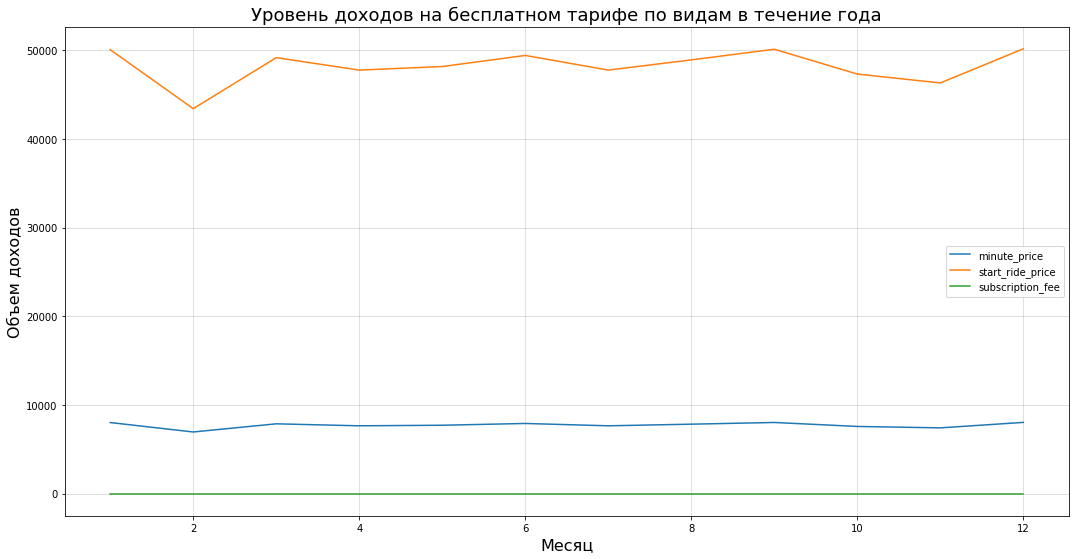

In [97]:
free_pivot = pd.pivot_table(free_data, 
               index=data['date'].dt.month, 
               values=('minute_price', 'start_ride_price', 'subscription_fee'),                      
               aggfunc='sum') 
               
free_pivot.plot(figsize=(18, 9))
plt.title('Уровень доходов на бесплатном тарифе по видам в течение года', fontsize=18)
plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Объем доходов', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

**Вывод.**

На бесплатном тарифе основные доходы складываются за счет стимости начала поездки. Распределены они в течение года стабильно и равномерно, за исключением небольших снжений в феврале и ноябре.

Платная подписка

In [98]:
monts_ultra = data['date'].dt.month
result = ultra_data.groupby(monts_ultra).agg(['sum', 'mean'])
result.round(2)

user_id            age           distance           duration         \
         sum    mean    sum   mean         sum     mean       sum   mean   
date                                                                       
1     210599  360.61  14536  24.89  1797157.59  3077.32  10795.52  18.49   
2     157201  335.90  11622  24.83  1451161.34  3100.77   8784.17  18.77   
3     196798  350.80  14033  25.01  1754942.47  3128.24  10349.79  18.45   
4     185046  335.84  13724  24.91  1714567.79  3111.74  10213.20  18.54   
5     213094  356.94  14876  24.92  1865940.51  3125.53  11145.72  18.67   
6     191681  339.26  14129  25.01  1761288.33  3117.32  10496.37  18.58   
7     205594  358.18  14465  25.20  1808672.98  3151.00  10685.70  18.62   
8     187893  347.95  13447  24.90  1685304.47  3120.93  10083.72  18.67   
9     177829  345.30  12795  24.84  1586998.95  3081.55   9527.59  18.50   
10    185569  350.79  13069  24.71  1660139.65  3138.26   9726.07  18.39   
11    175190  356.08  12065  24.52  1528603.84  3106.92   9110.21  18.52   
12    180221  343.93  13041  24.89  1635617.09  3121.41   9604.83  18.33   

     month      minute_price      start_ride_price      subscription_fee       
       sum mean          sum mean              sum mean              sum mean  
date                                                                           
1      584    1         3504    6                0    0           116216  199  
2      936    2         2808    6                0    0            93132  199  
3     1683    3         3366    6                0    0           111639  199  
4     2204    4         3306    6                0    0           109649  199  
5     2985    5         3582    6                0    0           118803  199  
6     3390    6         3390    6                0    0           112435  199  
7     4018    7         3444    6                0    0           114226  199  
8     4320    8         3240    6                0    0           107460  199  
9     4635    9         3090    6                0    0           102485  199  
10    5290   10         3174    6                0    0           105271  199  
11    5412   11         2952    6                0    0            97908  199  
12    6288   12         3144    6                0    0           104276  199

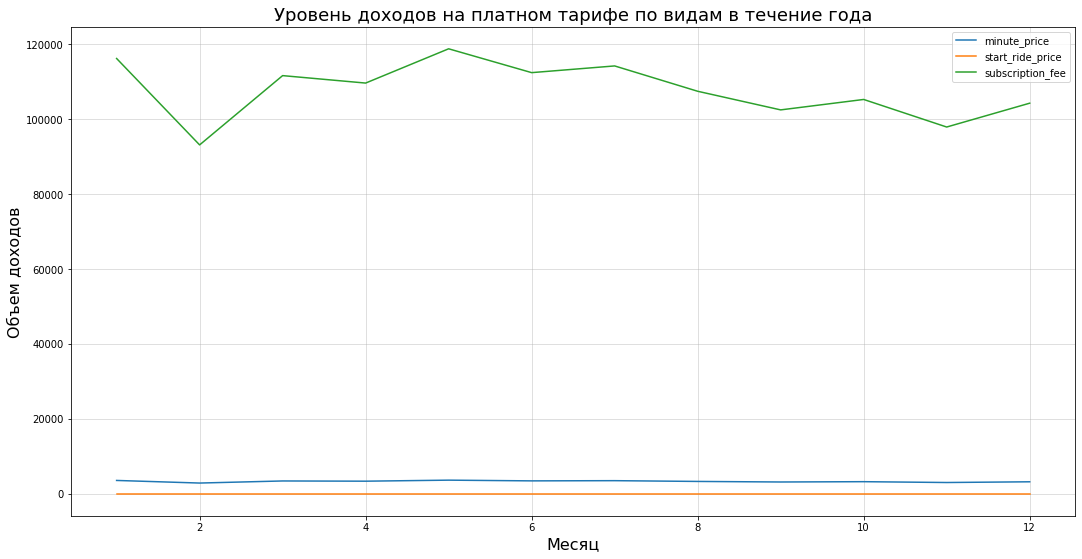

In [99]:
ultra_pivot = pd.pivot_table(ultra_data, 
               index=data['date'].dt.month, 
               values=('minute_price', 'start_ride_price', 'subscription_fee'),                      
               aggfunc='sum') 
               
ultra_pivot.plot(figsize=(18, 9))
plt.title('Уровень доходов на платном тарифе по видам в течение года', fontsize=18)
plt.xlabel('Месяц', fontsize=16)
plt.ylabel('Объем доходов', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

**Вывод.**

На платном тарифе основной вид доходов составляет плата за подписку, и он значительно выше, чем основной вид дохода на бесплатном тарифе - плата за начало поездки. Но, динамика дохода в течение года от этих двух видов доходов схожая - равномерно в течение года с небольшими снижениями в феврале и ноябре.

**Показатели ежемесячной выручки.**

In [100]:
data3 = data2.copy()

In [101]:
x = 'subscription_fee'
y = 'revenue'

In [102]:
data3.groupby(x)[y].mean().round(1).to_frame()

,revenue
subscription_fee,
0,328.6
199,362.8


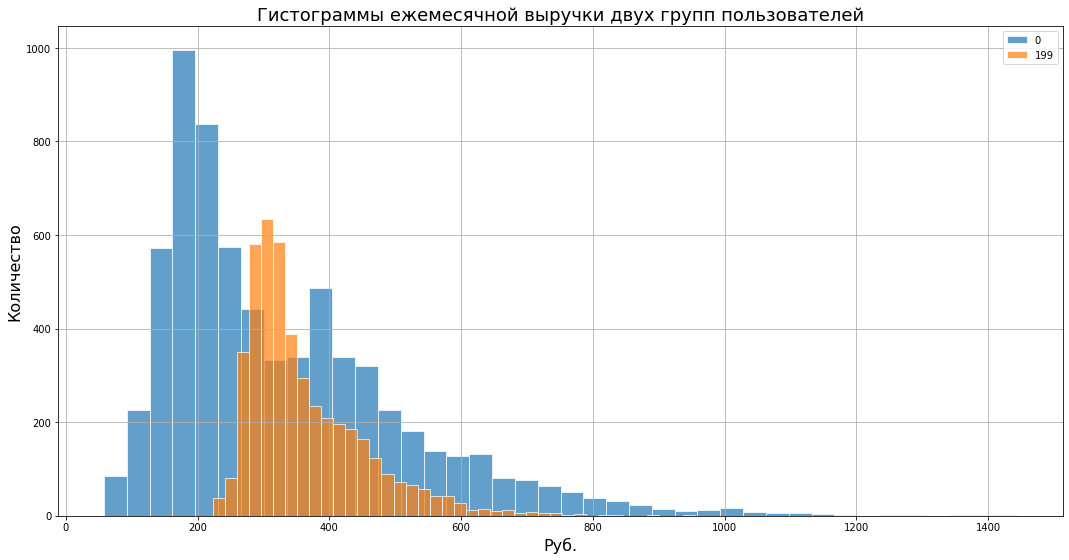

In [103]:
data3.groupby(x)[y].hist(figsize=(18, 9), bins=40, legend=True, ec='white', alpha=0.7)
plt.title('Гистограммы ежемесячной выручки двух групп пользователей', fontsize=18)
plt.xlabel('Руб.', fontsize=16)
plt.ylabel('Количество', fontsize=16)
plt.show(close=None, block=None)

#### Шаг 6. Проверка гипотез

##### **Важно понять, тратят ли пользователи с подпиской больше времени на поездки?**

**Проверка гипотезы:**

**Гипотеза H0:** Средняя продолжительность поездок с подпиской и без подписки равны.

**Гипотеза H1:** Средняя продолжительность поездок с подпиской больше, чем без подписки.

In [104]:
ultra = ultra_data['duration']
free = free_data['duration']

alpha = 0.05

results = st.ttest_ind(ultra, free, alternative='greater')

print(f'p-значение: {results.pvalue}')

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу')
else:
    print(f'Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Преобразование научного числа в целое

In [105]:
n = 1.2804098316645618e-34
print(f'{n:.50f}')

0.00000000000000000000000000000000012804098316645618


По итогам проверки гипотеза отвергнута, значит средняя продолжительность поездок с подпиской больше, чем без подписки.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

**Проверка гипотезы:**

**Гипотеза Н0:** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно оптимальному расстоянию в 3130 метров.

**Гипотеза Н1:** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше оптимального в 3130 метров.

In [106]:
ultra = ultra_data['distance']
value = 3130.0

alpha = 0.05

results = st.ttest_1samp(ultra, value, alternative='greater')

print(f'p-значение: {results.pvalue}')

if (results.pvalue < alpha):
    print(f'Отвергаем нулевую гипотезу')
else:
    print(f'Не отвергаем нулевую гипотезу')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод:**

По итогам проверки нулевая гипотеза о том, что пользователи с подпиской за одну поездку проездают среднее расстояние, равное оптимальному расстоянию в 3130 метров, не отвергнута. Пользователи с платной подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Проверка гипотезы:**

**Гипотеза Н0:** Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

**Гипотеза Н1:** Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [107]:
ultra_revenue = data2.loc[data2.subscription_fee > 0, 'revenue'] 

free_revenue = data2.loc[data2.subscription_fee == 0, 'revenue'] 

results = st.ttest_ind(ultra_revenue, free_revenue, alternative='greater')

alpha = 0.05

print(f'p-значение: {results.pvalue}')

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу')
else:
    print(f'Не удалось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [108]:
n = 1.8850394384715216e-31
print(f'{n:.50f}')

0.00000000000000000000000000000018850394384715216497


**Вывод:**

По итогам проверки гипотеза отвергнута, значит помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Проверить, равны ли совокупности до и после этого изменения для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel(). Будем проверять одностороннюю гипотезу.

Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.¶

1. Построим график с распределением вероятности для биномиальной случайной величины с p=0.1 и n=100 (по условию задачи):

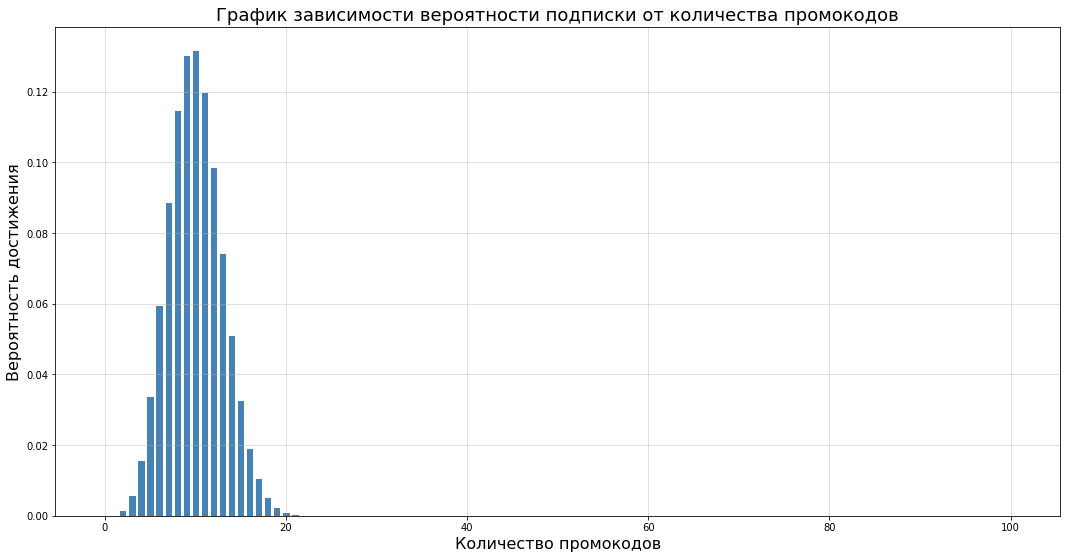

In [109]:
n = 100
p = 0.1

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n-k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)
    
plt.figure(figsize=(18, 9))
plt.bar(range(0, n + 1), distr, color='steelblue', ec='white')
plt.title('График зависимости вероятности подписки от количества промокодов', fontsize=18)
plt.xlabel('Количество промокодов', fontsize=16)
plt.ylabel('Вероятность достижения', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

**Вывод:**

График показывает, что при вероятности успеха p, равной 10%, и 100 попытках (n), вероятность, что случится больше 22 успехов, крайне мала. В нашем случае по плану нужно получить 100 успехов (100 продления подписок), в том числе, чтобы по условиям задачи вероятность не выполнить план была примерно 5% (т.е. выполнения плана минимум на 95%, что составляет 95 подписок). Таким образом, необходимо повышение числа n до выполнения условия задачи в 95 успехов.

2. Проверим условие хорошей аппроксимации.

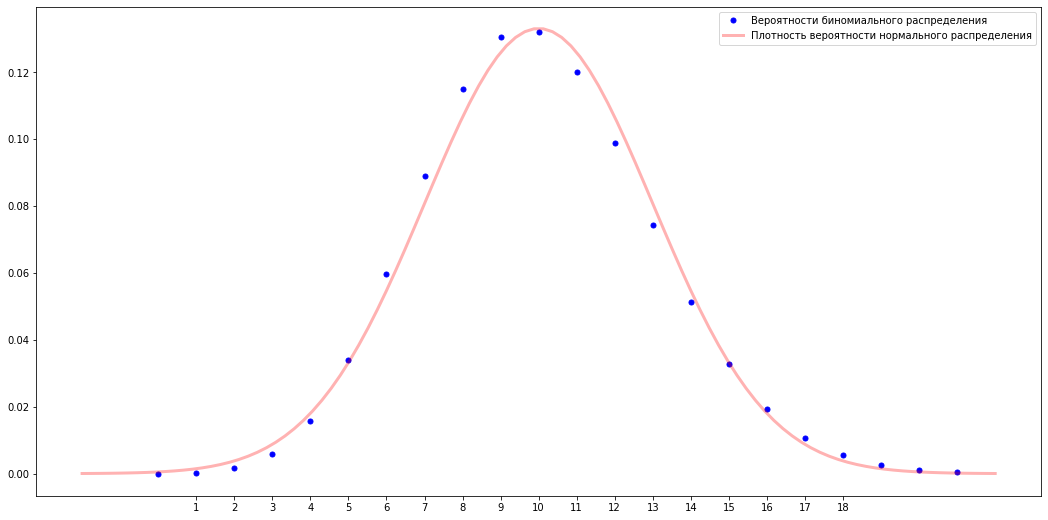

Условие выполняется


In [110]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
     
n = 100
p = 0.1

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right))

plt.figure(figsize=(18, 9))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='Вероятности биномиального распределения')

mu = n * p
sigma = sqrt(n * p * (1 - p))
 
x = linspace(left, right, 100)

ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='Плотность вероятности нормального распределения')
 
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

ax.legend(loc='best')
plt.show()

if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print(f'Условие выполняется')
else:
    print(f'Условие не выполняется')

**Вывод:**

График показывает, что условие аппроксимации выполняется. Промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения лежит в пределах [0, n] (т. е. там, где биномиальное распределение определено). Его его форма симметрична и близка к нормальному распределению.

3. Аппроксимируем биномиальное распределение нормальным.

In [111]:
n = 100 # необходимое количество клиентов, продливших подписку (по заданию 100 чел.) 
p = 0.1 # вероятность продления подписки (подписку продлевали ранее 10% пользователей)

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p  
sigma = sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma) # задаём нормальное распределение

result = 1 - distr.cdf(100) # находим вероятность не выполнить план в 5% (по заданию), т.е. выполнение на 95% или 95 подписок.
print(result)

0.0


Получили 0%. Будем увеличивать и подбирать параметр n до получения 100% успехов (95 подписок)

In [112]:
n = 1169 
p = 0.1 

mu = n * p  
sigma = sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma) 

result = 1 - distr.cdf(100) 
print(result)

0.9502851068730583


**Вывод.**

Для получения 100 подписчиков в 95% вероятностью необходимо разослать 1169 промокодов.

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 11 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

1. Построим график с распределением вероятности для биномиальной случайной величины:

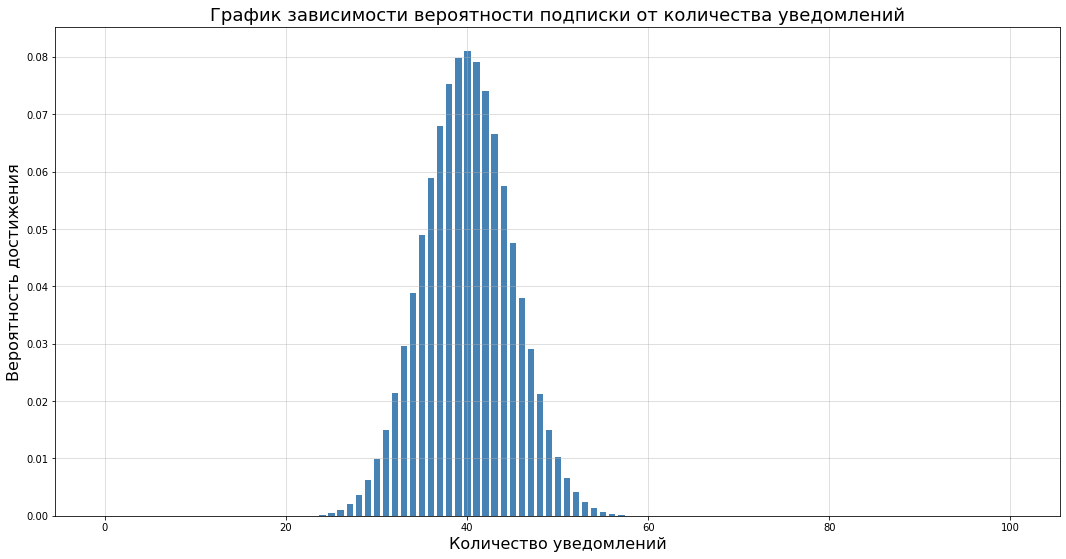

In [113]:
n = 100
p = 0.4

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n-k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)
    

plt.figure(figsize=(18, 9))
plt.bar(range(0, n + 1), distr, color='steelblue', ec='white')
plt.title('График зависимости вероятности подписки от количества уведомлений', fontsize=18)
plt.xlabel('Количество уведомлений', fontsize=16)
plt.ylabel('Вероятность достижения', fontsize=16)
plt.grid(alpha=0.5)
plt.show(close=None, block=None)

**Вывод:**

График показывает, что при вероятности успеха p, равной 40%, и 100 попытках, вероятность, что случится больше 59 успехов, крайне мала.

2. Проверим условие хорошей аппроксимации.

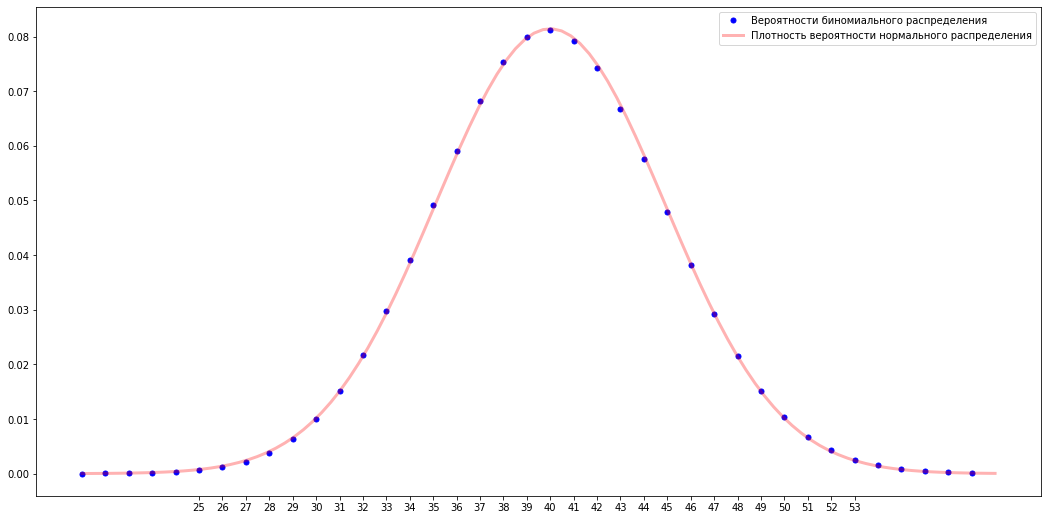

Условие выполняется


In [114]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
    
n = 100
p = 0.4

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right))

plt.figure(figsize=(18, 9))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='Вероятности биномиального распределения')


mu = n * p
sigma = sqrt(n * p * (1 - p))
 
x = linspace(left, right, 100)

ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='Плотность вероятности нормального распределения')
 
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

ax.legend(loc='best')
plt.show()

if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print(f'Условие выполняется')
else:
    print(f'Условие не выполняется')

**Вывод:**

График показывает, что условие аппроксимации выполняется. Промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения лежит в пределах [0, n] (т. е. там, где биномиальное распределение определено). Его его форма симметрична и близка к нормальному распределению.

3. Аппроксимируем биномиальное распределение нормальным.

In [115]:
n = 997490  
p = 0.4 


mu = n * p  
sigma = sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma) 

result = 1 - distr.cdf(399500) 
print(result)

0.15148640162457827


**Вывод:**

С 15% вероятностью письмо откроют не более 399500 при количестве рассылок, равному 997490.

**ИТОГОВЫЙ ВЫВОД:**

1. Пользователями самокатов являются люди в возрасте от 12 до 43 лет. Средний и медианный возраст пользователей практически равны и составляют 24,9 и 25 лет соответственно, мода возраста также равна 25 годам. Пользователи по возрасте от 23 до 27 лет включительно являются наибольшими возрастными группами, входят в топ 5 по возрасту и занимают почти 40% (39.7) всех пользователей. Средний и медианный возрасты пользователей с подпиской и без подписки не различаются. Значения минимального возраста также идентичны, а максимального возраста немного различаются. Вместе с тем, можно сделать вывод, что средний возраст заметного влияния на тип подписки не имеет.

2. В наборе данных представлены пользователи из 8 городов, количество которых между городами распределено равномерно в интервале от 11% до 14%. Наибольшее число пользователей в Пятигорске (219 человек), наименьшее в Москве (168). Среднее количество пользователей и медианное пратически совпадают и составляют 191.7 и 191 соответственно.

3. На показатели в Москве вероятнее всего влияет уровень дохода населения, который выше, чем в других регионах и позволяет приобрести самокат или автомобиль, а не брать его в аренду. Во-вторых, в Москве расстояния от дома до работы и обратно, или от дома до иных объектов может значительно превышать это же расстояние по сравнению с другими небольшими и компактно построенными городами. Такое расстояние может бать тяжело преодолимым на самокате. В третьих, несколько городов с большим количеством пользователей находятся на юге России (Сочи, Краснодар, Пятигорск, Ростов-на-Дону), что является также более благоприпятствующим фактором для поездок на самокате.

4. Для бизнеса необходимо знать, что на платном тарифе основной вид доходов составляет плата за подписку, и он значительно выше, чем основной вид дохода на бесплатном тарифе - плата за начало поездки. Но, динамика этих двух доходов в течение года одинаковая - равномерно распределены в течение года с небольшими снижениями в феврале и ноябре. Это необходимо использовать при организации проката и прогнозиорвании прибыли.

5. Каждый пользователь имеет одну из двух видов подписок - бесплатную или ультра. Доля пользователей имеющих бесплатную подписку составляет 54% (835 подписок), а доля имеющих подписку ультра - 46% (699 подписок). Ни в одном из городов общее число платных подписок не превышает общее число бесплатных. Только в Москве эти показатели равны (84 платных и 84 бесплатных). В целом рост платных подписок идет до 24 лет, а бесплатных подписок до 25 лет. После этого, число подписок равномерно идет на снижение. Также выявлено, что в отдельных возрастных категориях число платных подписок превышает число бесплатных: 15, 19, 31, 32, 33, 35 и 38 лет. В работе при планировании и проведении работы по прокату эти возрастные категории можно выделить в отдельный сегмент и строить с ними отдельную работу для сохранения доходности, а также проводить целевую работу по привлечению дополнительных пользователей их указанных возратных категорий.

6. Пользователи самокатов проезжают самые различные расстояния, среди которых минимальное расстояние зафиксировано менее 1 метра, а максимальное 7211 метр. Среднее и медианные значения практически равны 3070.6 и 3133.6 соответственно. Среднее и медианное значения дистанции у пользователей с бесплатной подпиской практически совпадает с пользователями с платной подпиской, но все равно оказывается немного ниже.

7. Продолжительность поездок также содержить большое число уникальных значений. Минимальное значение продолжительности 0.5 минуты, а максимальное 40.8 минут. Длительность средней сессии зафиксирована в 17.8 мин., а медианная в 17.6 мин. Стандартное отклонение - 6.0 мин. Средняя и медианная продолжительность поездки немного ниже у пользователей с бесплатной подпиской.

8. Между расстоянием поездки и продолжительностью сессии имеется средняя корреляция (0.53). Имеется явная закономерность при увеличении расстояния растет время поездки и, наоборот.

9. Зная средние средние значения расстояния и длительности поездок, можно формировать тарифы на поездки. Например, ориентируясь на потребности пользователей подготовить наиболее выгодный тариф для них и связать его со средней дистанцией или временем. Таким образом, можно расчитывать в перспективе на увеличение количества пользователей и, соответственно, ожидаемой прибыли (увеличение выручки от реализации большего количества услуг).

10. Изучение календарных дат поездок позволило выявить следующее. По месяцам в году все поездки распределены практически равномерно, но имеется незначительное снижение в осенне-зимний период. Распределение поездок по дням недели также имеет равномерную структуру, которая показывает отсутствие каких-либо закономерностей по увеличению или снижению числа поездок в будние дни или в выходные дни. Это хорошие показатели, которые показывают востребованность услуг в течение календарного года без провалов и проседаний.

11. Проверка гипотез показала следующие результаты:
+ Средняя продолжительность поездки различна от типа подписки. С платной подпиской она больше. С платным тарифом чем больше поездка, тем выгоднее.
+ Пользователи с платной подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.
+ Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

12. В ходе решения задач на распределения выявлено:
+ Для получения 100 подписчиков в 95% вероятностью необходимо разослать 1169 промокодов.
+ С 15% вероятностью письмо откроют не более 399500 при количестве рассылок, равному 997490.